**ALGORITHM IMPLEMENTATION**

In [ ]:
!pip install torch_geometric

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader, Dataset
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
from tqdm.auto import tqdm

In [ ]:
#Reproducibility - fix random seeds to ensure reproducibility of splits and results
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

plt.rcParams['figure.figsize'] = (6, 4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T, K = 12, 3
BATCH_SIZE = 32

*`DATA LOADING`*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Project Work/data.txt'
df = pd.read_csv(file_path, sep=r'\s+', header=None,
                 names=['date','time','epoch','sensor_id','temp','hum','light','volt'],
                 on_bad_lines='skip')
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
df.dropna(subset=['datetime'], inplace=True)
print(f"Dataset: {df.shape[0]} rows, {df['sensor_id'].nunique()} sensors")
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset: 2313678 rows, 61 sensors


,date,time,epoch,sensor_id,temp,hum,light,volt,datetime
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397,2004-03-31 03:38:15.757551
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964,2004-02-28 00:59:16.027850
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742,2004-02-28 01:03:16.333930
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742,2004-02-28 01:06:16.013453
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964,2004-02-28 01:06:46.778088


*`DATA PREPROCESSING AND CLEANING`*

/tmp/ipython-input-751186940.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=miss.index, y=miss.values, palette='Blues_d')


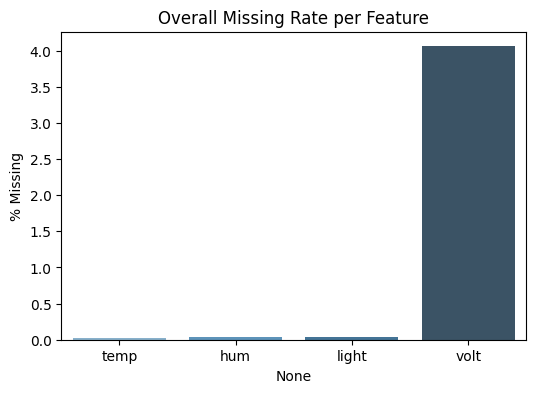

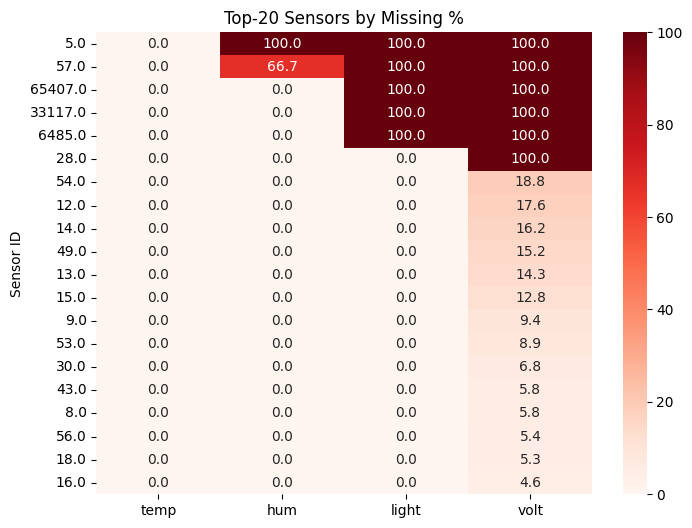

In [ ]:
#Missingness overview
sensor_cols = ['temp','hum','light','volt']

miss = df[sensor_cols].isna().mean()*100
plt.figure(figsize=(6,4))
sns.barplot(x=miss.index, y=miss.values, palette='Blues_d')
plt.ylabel('% Missing'); plt.title('Overall Missing Rate per Feature'); plt.show()

ms_by_sensor = df.groupby('sensor_id')[sensor_cols].apply(lambda g: g.isna().mean()*100)
top20 = ms_by_sensor.mean(axis=1).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.heatmap(ms_by_sensor.loc[top20.index], annot=True, fmt=".1f", cmap='Reds')
plt.title('Top-20 Sensors by Missing %'); plt.ylabel('Sensor ID'); plt.show()

In [ ]:
#Drop sensors with extreme missingness - avoid noisy fillers
drop_thresh = 50 #50% threshold
to_drop = ms_by_sensor.max(axis=1).loc[lambda s: s > drop_thresh].index
df_ = df[~df['sensor_id'].isin(to_drop)].copy()
print(f"Dropped {len(to_drop)} sensors >{drop_thresh}% missing.")

Dropped 6 sensors >50% missing.


In [ ]:
#Fill missing values: per-sensor ffill/bfill, then global mean - preserve continuity, mean as last resort
def comprehensive_fill(dfin, cols=sensor_cols):
    d = dfin.copy()
    #per-sensor ffill→bfill
    filled = (d.groupby('sensor_id')[cols]
                .apply(lambda g: g.ffill().bfill())
                .reset_index(level=0, drop=True))
    d[cols] = filled

    d[cols] = d[cols].fillna(d[cols].mean())
    return d

Removed 383769 outlier rows


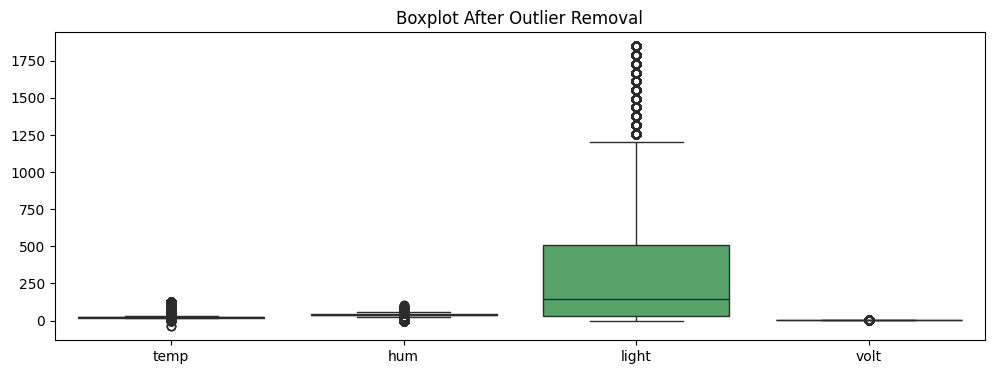

In [ ]:
#Outlier removal per sensor
def remove_outliers_per_sensor(dfin, cols=sensor_cols):
    d = dfin.copy()
    keep_idx = []
    for sid, g in d.groupby('sensor_id'):
        mask = np.ones(len(g), dtype=bool)
        for c in cols:
            q1, q3 = g[c].quantile([.25, .75])
            iqr = q3 - q1
            lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
            mask &= (g[c] >= lo) & (g[c] <= hi)
        keep_idx.append(g.loc[mask].index)
    keep_idx = np.concatenate(keep_idx) if keep_idx else np.array([], dtype=int)
    return d.loc[keep_idx].copy()

df_filled = comprehensive_fill(df_) #Call the fill function and assign to df_filled
before_n = len(df_filled)
df_clean = remove_outliers_per_sensor(df_filled, sensor_cols)
print(f"Removed {before_n - len(df_clean)} outlier rows")

plt.figure(figsize=(12,4))
sns.boxplot(data=df_clean[sensor_cols], palette='Greens')
plt.title('Boxplot After Outlier Removal'); plt.show()

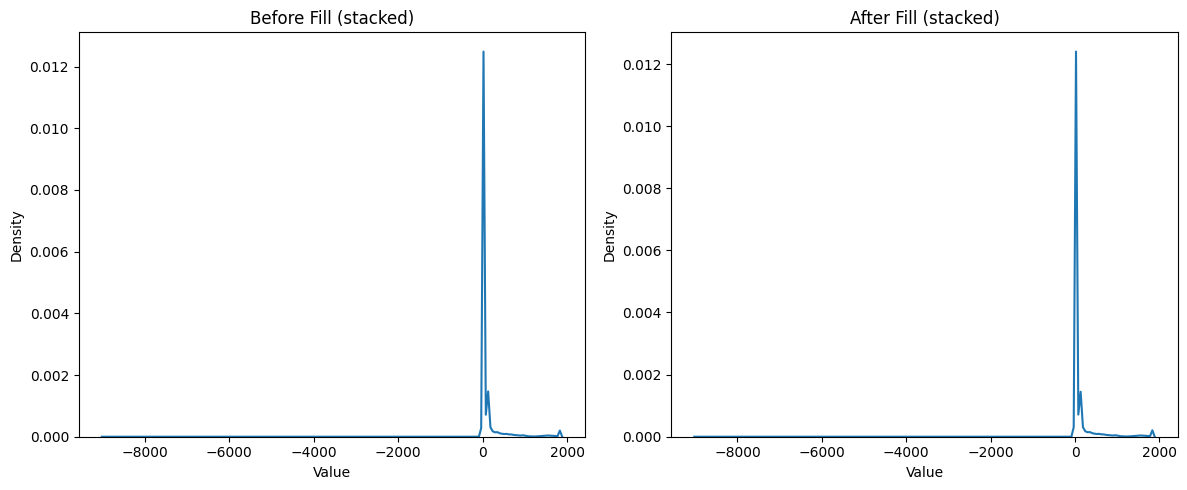

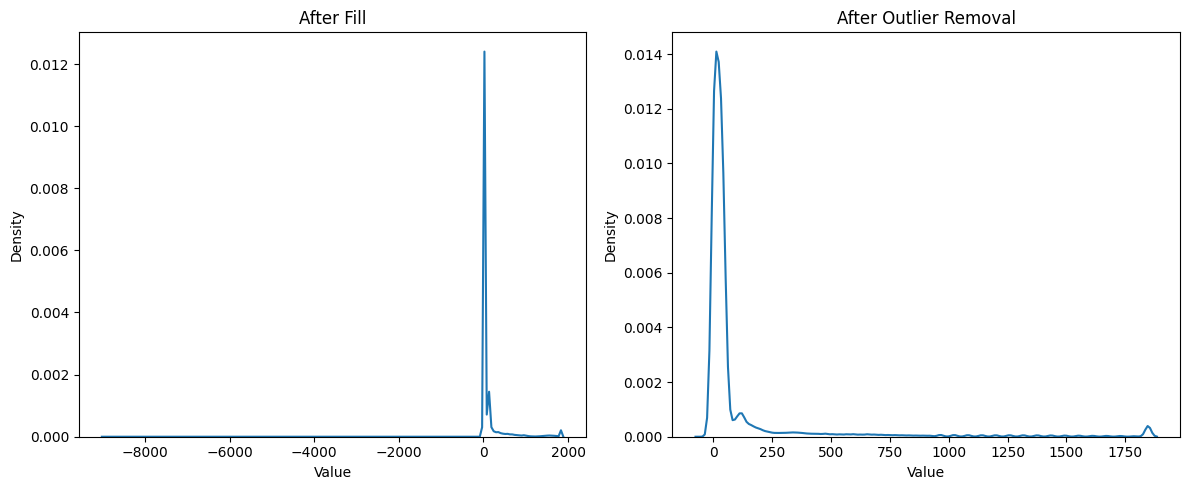

In [ ]:
#Distribution check
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.kdeplot(df[sensor_cols].stack(), ax=axes[0]); axes[0].set_title('Before Fill (stacked)'); axes[0].set_xlabel('Value')
sns.kdeplot(df_filled[sensor_cols].stack(), ax=axes[1]); axes[1].set_title('After Fill (stacked)'); axes[1].set_xlabel('Value')
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.kdeplot(df_filled[sensor_cols].stack(), ax=axes[0]); axes[0].set_title('After Fill'); axes[0].set_xlabel('Value')
sns.kdeplot(df_clean[sensor_cols].stack(), ax=axes[1]); axes[1].set_title('After Outlier Removal'); axes[1].set_xlabel('Value')
plt.tight_layout(); plt.show()

In [ ]:
#Data quality summary
initial_rows = len(df)
print("\nDATA QUALITY SUMMARY")
print(f"Initial rows: {initial_rows}")
print(f"After missing fill: {len(df_filled)}")
print(f"After outlier removal: {len(df_clean)}")
print(f"Retention: {len(df_clean)/initial_rows*100:.1f}%")


DATA QUALITY SUMMARY
Initial rows: 2313678
After missing fill: 2267196
After outlier removal: 1883427
Retention: 81.4%


In [ ]:
#Per sensor normalization
def normalize_per_sensor(dfin, cols=sensor_cols):
    d = dfin.copy()
    for sid, g in d.groupby('sensor_id'):
        mu = g[cols].mean()
        sd = g[cols].std().replace(0, 1.0)
        d.loc[g.index, cols] = (g[cols] - mu) / sd
    return d

base_df = normalize_per_sensor(df_clean)

print(base_df.shape)
display(base_df.head())

(1883427, 9)


,date,time,epoch,sensor_id,temp,hum,light,volt,datetime
1,2004-02-28,00:59:16.02785,3,1.0,-0.859096,-0.260368,-0.634152,1.161041,2004-02-28 00:59:16.027850
2,2004-02-28,01:03:16.33393,11,1.0,-1.154786,0.014926,-0.634152,1.043438,2004-02-28 01:03:16.333930
3,2004-02-28,01:06:16.013453,17,1.0,-1.213924,0.083468,-0.634152,1.043438,2004-02-28 01:06:16.013453
4,2004-02-28,01:06:46.778088,18,1.0,-1.209700,0.090302,-0.634152,1.161041,2004-02-28 01:06:46.778088
5,2004-02-28,01:08:45.992524,22,1.0,-1.222373,0.110845,-0.634152,1.043438,2004-02-28 01:08:45.992524


In [ ]:
chk = (base_df.groupby('sensor_id')[sensor_cols]
                  .agg(['mean','std']).round(3))
display(chk.head())

#ranges across sensors
print("Mean ranges:", chk.xs('mean', level=1, axis=1).min().to_dict(),
      "→", chk.xs('mean', level=1, axis=1).max().to_dict())
print("Std  ranges:", chk.xs('std',  level=1, axis=1).min().to_dict(),
      "→", chk.xs('std',  level=1, axis=1).max().to_dict())

temp       hum      light      volt     
          mean  std mean  std  mean  std mean  std
sensor_id                                         
1.0       -0.0  1.0 -0.0  1.0   0.0  1.0 -0.0  1.0
2.0       -0.0  1.0 -0.0  1.0  -0.0  1.0  0.0  1.0
3.0       -0.0  1.0 -0.0  1.0   0.0  1.0  0.0  1.0
4.0       -0.0  1.0 -0.0  1.0  -0.0  1.0  0.0  1.0
6.0        0.0  1.0  0.0  1.0   0.0  1.0 -0.0  1.0

Mean ranges: {'temp': 0.0, 'hum': -0.0, 'light': -0.0, 'volt': 0.0} → {'temp': 0.0, 'hum': -0.0, 'light': -0.0, 'volt': 0.0}
Std  ranges: {'temp': 1.0, 'hum': 1.0, 'light': 1.0, 'volt': 1.0} → {'temp': 1.0, 'hum': 1.0, 'light': 1.0, 'volt': 1.0}


*`EDA - READINGS PER SENSOR`*

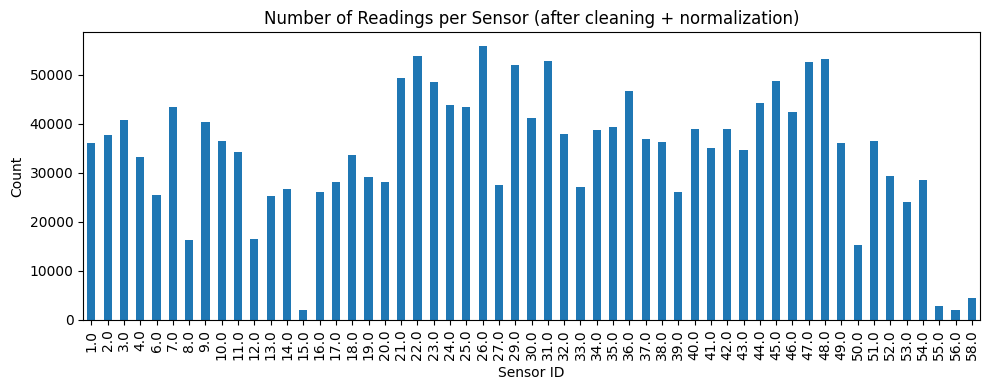

In [ ]:
#Readings per sensor
sensor_cols = ['temp','hum','light','volt']
counts = base_df['sensor_id'].value_counts().sort_index()
plt.figure(figsize=(10,4))
counts.plot.bar()
plt.xlabel("Sensor ID"); plt.ylabel("Count")
plt.title("Number of Readings per Sensor (after cleaning + normalization)")
plt.tight_layout(); plt.show()

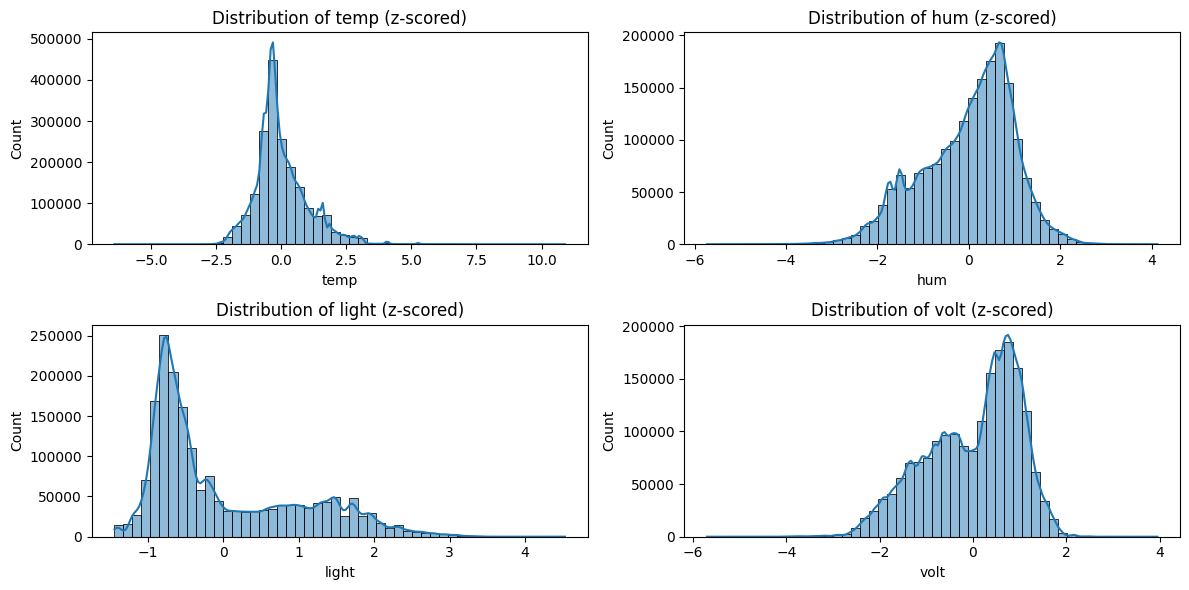

In [ ]:
#Reading distribution by feature
plt.figure(figsize=(12,6))
for i, c in enumerate(sensor_cols, 1):
    plt.subplot(2,2,i)
    sns.histplot(base_df[c], bins=50, kde=True)
    plt.title(f"Distribution of {c} (z-scored)")
plt.tight_layout(); plt.show()

In [ ]:
#Normality and skewness summary for each feature
assert 'base_df' in globals(), "base_df not found"
sensor_cols = ['temp','hum','light','volt']
assert set(sensor_cols).issubset(base_df.columns), "Missing expected sensor columns"

from scipy import stats

def _skew_label(v: float) -> str:
    if abs(v) < 0.3: return "~symmetric"
    if 0.3 <= v < 1.0: return "slightly right-skewed"
    if -1.0 < v <= -0.3: return "slightly left-skewed"
    if v >= 1.0: return "right-skewed"
    return "left-skewed"

rows, alpha = [], 0.05
rng = np.random.default_rng(42)

for col in sensor_cols:
    x = base_df[col].dropna()
    n = len(x)
    x_test = x if n <= 50000 else x.iloc[rng.choice(n, 50000, replace=False)]
    k2, p = stats.normaltest(x_test.values)
    skew = stats.skew(x, bias=False)
    kurt = stats.kurtosis(x, fisher=True, bias=False)
    approx_normal = (p >= alpha) and (abs(skew) < 0.3)

    rows.append({
        "feature": col,
        "n": n,
        "skew": round(skew, 3),
        "excess_kurtosis": round(kurt, 3),
        "p_normaltest": float(p),
        "approx_normal@0.05": approx_normal,
        "shape": "approximately normal" if approx_normal else _skew_label(skew),
    })

dist_summary = pd.DataFrame(rows).set_index("feature").loc[sensor_cols]
display(dist_summary)

for f, r in dist_summary.iterrows():
    print(f"- {f}: {r['shape']}; skew={r['skew']}, excess kurtosis={r['excess_kurtosis']}, p={r['p_normaltest']:.3g}")

,n,skew,excess_kurtosis,p_normaltest,approx_normal@0.05,shape
feature,,,,,,
temp,1883427,1.051,2.547,0.0,False,right-skewed
hum,1883427,-0.535,-0.022,0.0,False,slightly left-skewed
light,1883427,0.951,-0.224,0.0,False,slightly right-skewed
volt,1883427,-0.550,-0.471,0.0,False,slightly left-skewed


- temp: right-skewed; skew=1.051, excess kurtosis=2.547, p=0
- hum: slightly left-skewed; skew=-0.535, excess kurtosis=-0.022, p=0
- light: slightly right-skewed; skew=0.951, excess kurtosis=-0.224, p=0
- volt: slightly left-skewed; skew=-0.55, excess kurtosis=-0.471, p=0


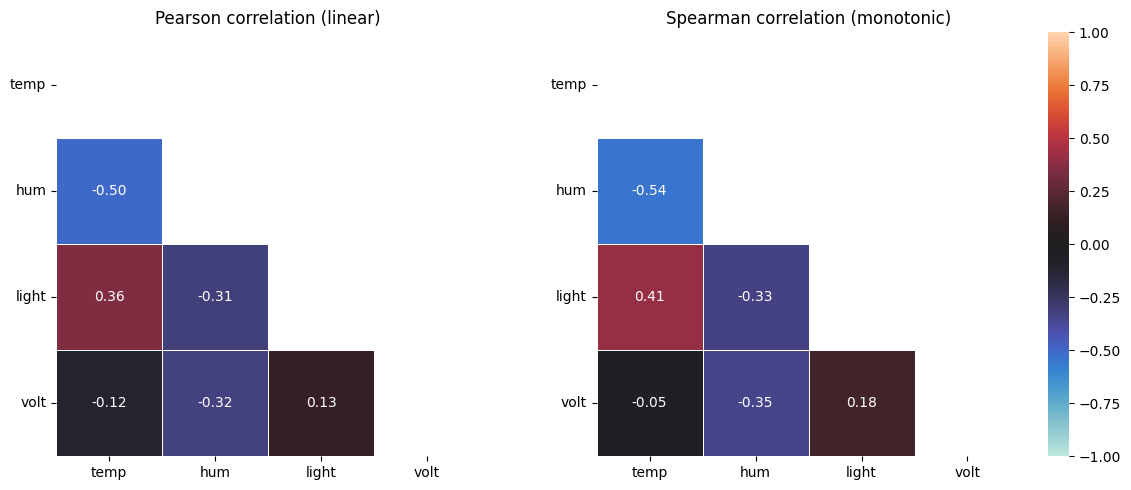

Top Pearson pairs: {('temp', 'hum'): -0.505, ('hum', 'temp'): -0.505, ('temp', 'light'): 0.358}
Top Spearman pairs: {('temp', 'hum'): -0.541, ('hum', 'temp'): -0.541, ('temp', 'light'): 0.413}


In [ ]:
#Correlation heatmap across features
features = ['temp','hum','light','volt']
X = base_df[features].dropna(how='any')
assert not X.empty, "No data available for correlation heatmap"

corr_pear = X.corr(method='pearson')
corr_spea = X.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
mask = np.triu(np.ones_like(corr_pear, dtype=bool))

sns.heatmap(corr_pear, ax=axes[0], annot=True, fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, mask=mask, cbar=False)
axes[0].set_title("Pearson correlation (linear)")
sns.heatmap(corr_spea, ax=axes[1], annot=True, fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, mask=mask, cbar=True)
axes[1].set_title("Spearman correlation (monotonic)")
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout(); plt.show()

def _top_pairs(corr):
    s = corr.where(~np.eye(len(corr), dtype=bool)).stack()
    return s.reindex(s.abs().sort_values(ascending=False).index).head(3).round(3).to_dict()

print("Top Pearson pairs:", _top_pairs(corr_pear))
print("Top Spearman pairs:", _top_pairs(corr_spea))

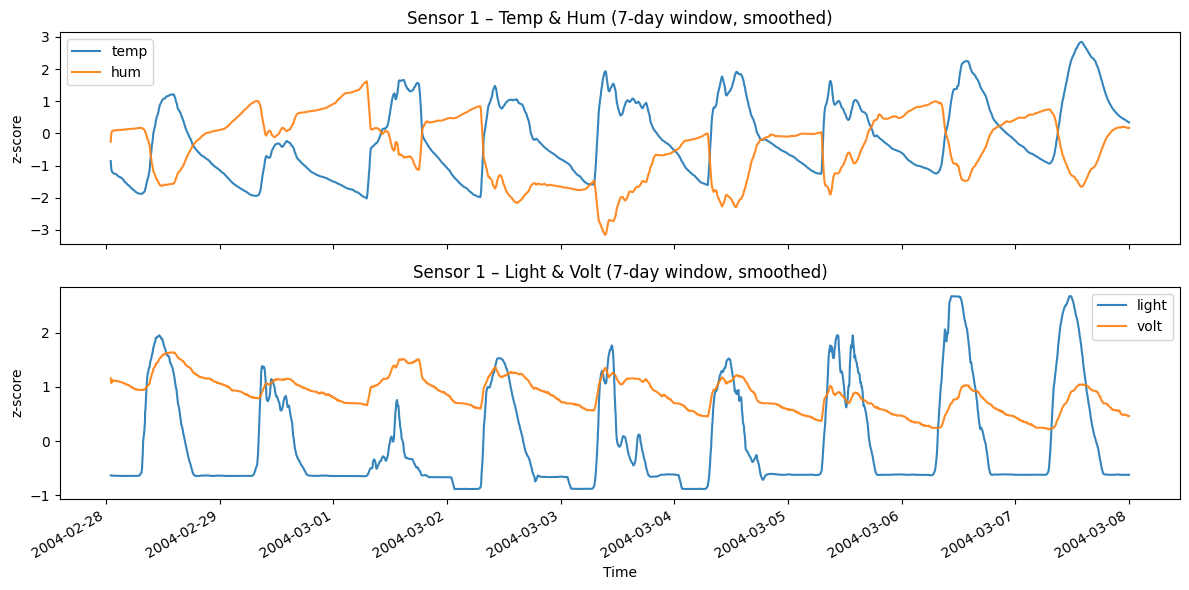

In [ ]:
#Time series snapshot for sensor 1
sid_example = 1
sub = (base_df[base_df['sensor_id']==sid_example]
       .sort_values('datetime')
       .set_index('datetime')[sensor_cols])

#Fixed 7-day window
sub_week = sub.loc['2004-02-28':'2004-03-07']

#Smooth with rolling mean
sub_smooth = sub_week.rolling(window=60, min_periods=1).mean()

#Plot in 2 panels: (temp + hum) and (light + volt)
fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)

sub_smooth[['temp','hum']].plot(ax=axes[0], alpha=0.9)
axes[0].set_title(f"Sensor {sid_example} – Temp & Hum (7-day window, smoothed)")
axes[0].set_ylabel("z-score")

sub_smooth[['light','volt']].plot(ax=axes[1], alpha=0.9)
axes[1].set_title(f"Sensor {sid_example} – Light & Volt (7-day window, smoothed)")
axes[1].set_ylabel("z-score")

plt.xlabel("Time")
plt.tight_layout(); plt.show()

In [ ]:
#Completeness Check
sensor_compl = counts.rename("rows")  # keep sensor_id as index

print("Readings per sensor after preprocessing")
print(f"Min: {sensor_compl.min()}, "
      f"Median: {sensor_compl.median():.0f}, "
      f"Max: {sensor_compl.max()}, "
      f"Mean: {sensor_compl.mean():.1f}, "
      f"Std: {sensor_compl.std():.1f}")

# Calculate representative sensors
min_sensor = sensor_compl.idxmin()
median_sensor = (sensor_compl - sensor_compl.median()).abs().nsmallest(1).index[0]
max_sensor = sensor_compl.idxmax()
rep_sensors = f"Most: {max_sensor}, Median: {median_sensor}, Fewest: {min_sensor}"

print(f"Representative sensors (most/median/fewest): {rep_sensors}")

Readings per sensor after preprocessing
Min: 1981, Median: 36160, Max: 55814, Mean: 34244.1, Std: 13144.6
Representative sensors (most/median/fewest): Most: 26.0, Median: 38.0, Fewest: 15.0


*`BASELINE MODEL`*

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

#Define model
class TwoLayerGCN(nn.Module):
    def __init__(self, in_feats: int, hidden_feats: int, out_feats: int, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, out_feats)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self._reset_parameters()

    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, GCNConv):
                nn.init.xavier_uniform_(m.lin.weight)
                if m.lin.bias is not None:
                    nn.init.zeros_(m.lin.bias)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = self.relu(x)
        x = self.drop(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [ ]:
#Sanity check
torch.manual_seed(SEED)
graphs = []
for _ in range(2):
    num_nodes, in_feats, out_feats = 54, 12, 3
    x = torch.randn(num_nodes, in_feats) #[N, T]
    #random edges
    edge_index = torch.randint(0, num_nodes, (2, 270)) #[2, E]
    edge_weight = torch.ones(edge_index.size(1), dtype=torch.float32)
    y = torch.randn(num_nodes, out_feats)  #[N, K]
    graphs.append(Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y))

loader = DataLoader(graphs, batch_size=2, shuffle=True)

model = TwoLayerGCN(in_feats=12, hidden_feats=32, out_feats=3, dropout=0.2).to(device)
opt = Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

batch = next(iter(loader))
batch = batch.to(device)
model.train()
opt.zero_grad()
y_hat = model(batch.x, batch.edge_index, batch.edge_weight)   #[batch*N, K]
loss = mse(y_hat, batch.y.to(device))
loss.backward()
opt.step()

print(f"Sanity-check loss → {loss.item():.4f}, y_hat shape: {tuple(y_hat.shape)}")

Sanity-check loss → 1.1966, y_hat shape: (108, 3)


In [ ]:
#Hyperparameters summary
rows = []

def _add_row(name, params: dict, metrics: dict | None = None):
    d = {
        "model": name,
        "hidden_feats": params.get("hidden_feats"),
        "lr": params.get("lr"),
        "weight_decay": params.get("weight_decay"),
        "dropout": params.get("dropout"),
        "n_estimators": params.get("n_estimators"),
        "max_depth": params.get("max_depth"),
        "alpha": params.get("alpha"),
        "seed": params.get("seed"),
    }
    if metrics:
        d.update({
            "best_val_loss": metrics.get("best_val_loss"),
            "best_epoch": metrics.get("best_epoch"),
        })
    rows.append(d)

if "lin_model" in globals():
    try:
        p = getattr(lin_model, "get_params", lambda: {})()
        _add_row("Linear", {
            "alpha": p.get("alpha"),
            "seed": p.get("random_state"),
        })
    except Exception as e:
        print("Note: could not read Linear params:", e)


if "rf_model" in globals():
    try:
        p = getattr(rf_model, "get_params", lambda: {})()
        _add_row("RandomForest", {
            "n_estimators": p.get("n_estimators"),
            "max_depth": p.get("max_depth"),
            "seed": p.get("random_state"),
        })
    except Exception as e:
        print("Note: could not read RF params:", e)

#Detect GCN
if "model" in globals():
    try:
        g_hidden = getattr(model, "conv2").in_channels  #second layer input = hidden size
        g_drop = getattr(model, "drop", None).p if hasattr(getattr(model, "drop", None), "p") else None
        g_lr, g_wd = None, None
        if "opt" in globals():
            pg = opt.param_groups[0]
            g_lr, g_wd = pg.get("lr"), pg.get("weight_decay", 0.0)
        _add_row("GCN", {
            "hidden_feats": g_hidden,
            "dropout": g_drop,
            "lr": g_lr,
            "weight_decay": g_wd,
            "seed": globals().get("SEED"),
        })
    except Exception as e:
        print("Note: could not read GCN params:", e)

if not rows:
    _add_row("GCN", {
        "hidden_feats": 32, "dropout": 0.2, "lr": 1e-3, "weight_decay": 0.0, "seed": globals().get("SEED")
    })

hyperparam_table = pd.DataFrame(rows)
display(hyperparam_table.sort_values("model").reset_index(drop=True))

,model,hidden_feats,lr,weight_decay,dropout,n_estimators,max_depth,alpha,seed
0,GCN,32,0.001,0,0.2,None,None,None,42


*`DATASET PIPELINE`*

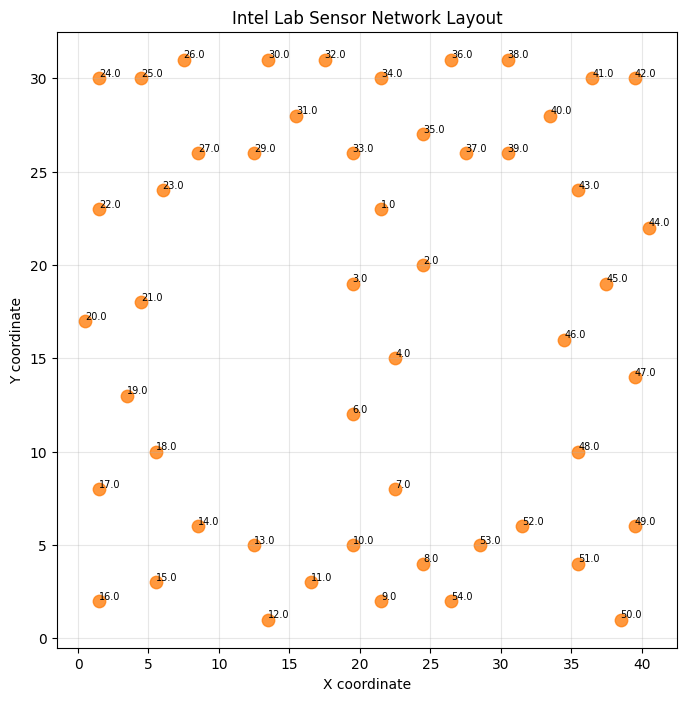

In [ ]:
#Load sensor graph
import requests
coords_txt = requests.get("https://db.csail.mit.edu/labdata/mote_locs.txt").text.strip().split("\n")
rows = []
for line in coords_txt:
    try:
        sid, x, y = line.split()
        rows.append((int(float(sid)), float(x), float(y)))
    except:
        pass
coords_df = pd.DataFrame(rows, columns=['sensor_id','x','y']).sort_values('sensor_id').reset_index(drop=True)

#Keep only sensors present in base_df
coords_df = coords_df[coords_df['sensor_id'].isin(base_df['sensor_id'].unique())].reset_index(drop=True)

#Plot sensor layout
plt.figure(figsize=(8,8))
plt.scatter(coords_df['x'], coords_df['y'], c='C1', s=80, alpha=0.8)
for _, row in coords_df.iterrows():
    plt.text(row['x'], row['y'], str(row.sensor_id),
             fontsize=7, ha='left', va='bottom', color='black')
    plt.title('Intel Lab Sensor Network Layout')
    plt.xlabel('X coordinate'); plt.ylabel('Y coordinate')
plt.grid(alpha=0.3)
plt.show()

Graph built → 52 nodes, 116 edges


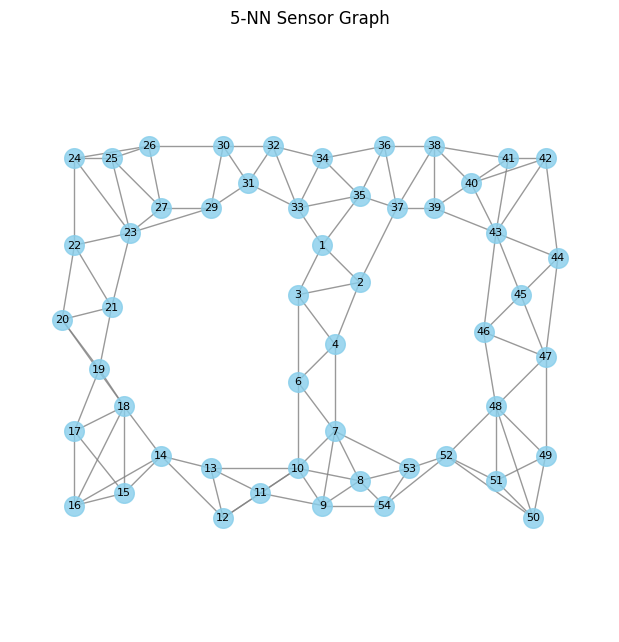

In [ ]:
#Build k-NN Sensor Graph
coords = coords_df[['x','y']].to_numpy()
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coords)
dists, idxs = nbrs.kneighbors(coords)

edges = set(); weights = {}; eps = 1e-6
for src in range(len(coords)):
    for j in range(1, 5):  # skip self
        dst = int(idxs[src, j])
        a, b = (src, dst) if src < dst else (dst, src)
        edges.add((a, b))
        w = 1.0 / (float(dists[src, j]) + eps)
        weights[(a, b)] = max(weights.get((a, b), 0.0), w)

edge_index_np = np.array(list(edges)).T
edge_index = torch.tensor(edge_index_np, dtype=torch.long)
edge_weight = torch.tensor([weights[(min(u,v), max(u,v))] for (u,v) in edges], dtype=torch.float32)

print(f"Graph built → {len(coords)} nodes, {edge_index.size(1)} edges")

G = nx.Graph()
G.add_nodes_from(range(len(coords)))
G.add_edges_from(edges)
pos = {i: (coords[i,0], coords[i,1]) for i in range(len(coords))}
plt.figure(figsize=(6,6))
nx.draw(G, pos, node_size=200, node_color='skyblue', edge_color='gray', alpha=0.8, with_labels=False)
for i, sid in enumerate(coords_df['sensor_id']):
    plt.text(coords[i,0], coords[i,1], str(sid), fontsize=8, ha='center', va='center')
plt.title("5-NN Sensor Graph"); plt.axis('equal'); plt.axis('off'); plt.show()

In [ ]:
#Build per-sensor time series dict (sorted by datetime)
series_dict = {}
for sid, g in base_df.sort_values('datetime').groupby('sensor_id'):
    series_dict[int(sid)] = {
        'X': g[sensor_cols].to_numpy(),
        'y': g['temp'].to_numpy()
    }

#Align sensor IDs
node_order_sids = coords_df['sensor_id'].astype(int).tolist()
common_sids = [sid for sid in node_order_sids if sid in series_dict]
print(f"Aligned {len(common_sids)} sensors between coords and data")

Aligned 52 sensors between coords and data


In [ ]:
#Build sliding window
min_len = min(len(series_dict[sid]['X']) for sid in common_sids)
windows = pd.DataFrame({'start_idx': np.arange(0, min_len - (T+K) + 1)})
print(f"Windows: {len(windows)} total")

Windows: 1967 total


In [ ]:
#Choosing 'T' and 'K'
def _acf(x, max_lag=72):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    x = (x - x.mean()) / (x.std() + 1e-9)
    ac = np.correlate(x, x, mode='full')[-len(x):]
    ac /= ac[0] if ac[0] != 0 else 1
    return ac[:max_lag+1]

max_lag = 72
acs = []
for sid, df in list(series_dict.items())[:min(30, len(series_dict))]:
    acs.append(_acf(df['y'], max_lag))
mean_acf = np.nanmean(np.vstack(acs), axis=0)
T_suggest = int(np.argmax(mean_acf < 0.2)) if np.any(mean_acf < 0.2) else 24

print(f"T currently used: {T}; suggested by ACF<0.2: {T_suggest} (cap={max_lag})")

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=min(10, len(coords)), algorithm='ball_tree').fit(coords)
dists, _ = nbrs.kneighbors(coords)
avg_deg_target = 5
avg_d_k = float(np.mean(dists[:, avg_deg_target-1]))
print(f"K currently used: {K}; avg distance to {avg_deg_target}th NN ≈ {avg_d_k:.2f}")
print("Rationale: T captures short-term dependence until ACF weakens; "
      "K=5 preserves connectivity without over-connecting.")

T currently used: 12; suggested by ACF<0.2: 24 (cap=72)
K currently used: 3; avg distance to 5th NN ≈ 6.36
Rationale: T captures short-term dependence until ACF weakens; K=5 preserves connectivity without over-connecting.


In [ ]:
#Define PyG dataset
class SensorWindowDataset(torch.utils.data.Dataset):
    def __init__(self, win_df, series_dict, node_order_sids, edge_index, edge_weight, T, K):
        self.win = win_df.reset_index(drop=True)
        self.sids = node_order_sids
        self.sd = series_dict
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.num_nodes = len(self.sids)
        self.T, self.K = T, K
        self.F = len(sensor_cols)
        # Create a mapping from sensor ID to node index
        self.sid_to_node_idx = {sid: i for i, sid in enumerate(self.sids)}


    def __len__(self): return len(self.win)

    def __getitem__(self, idx):
        start = int(self.win.loc[idx,'start_idx'])
        X_nodes, y_nodes, node_sids = [], [], [] # Add node_sids list
        for sid in self.sids:
            seqX = self.sd[sid]['X'][start:start+self.T, :]
            seqY = self.sd[sid]['y'][start+self.T:start+self.T+self.K]
            X_nodes.append(torch.tensor(seqX.reshape(self.T*self.F), dtype=torch.float32))
            y_nodes.append(torch.tensor(seqY, dtype=torch.float32))
            node_sids.append(sid) # Append the sensor ID

        x = torch.stack(X_nodes, 0)
        y = torch.stack(y_nodes, 0)
        # Include sensor_id in the Data object
        return Data(x=x, edge_index=self.edge_index, edge_weight=self.edge_weight, y=y, sensor_id=torch.tensor(node_sids, dtype=torch.long))

In [ ]:
#Train / val / test split
n = len(windows)
n_train, n_val = int(0.70*n), int(0.15*n)
df_shuf = windows.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
df_train, df_val, df_test = df_shuf.iloc[:n_train], df_shuf.iloc[n_train:n_train+n_val], df_shuf.iloc[n_train+n_val:]
print(f"Splits → train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")

Splits → train: 1376, val: 295, test: 296


In [ ]:
#Instantiate dataset and loaders
train_ds = SensorWindowDataset(df_train, series_dict, common_sids, edge_index, edge_weight, T, K)
val_ds   = SensorWindowDataset(df_val,   series_dict, common_sids, edge_index, edge_weight, T, K)
test_ds  = SensorWindowDataset(df_test,  series_dict, common_sids, edge_index, edge_weight, T, K)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, follow_batch=['sensor_id'])
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, follow_batch=['sensor_id'])
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, follow_batch=['sensor_id'])

x shape: torch.Size([1664, 48])  [batch*S, T*F]
edge_index: torch.Size([2, 3712])  edge_weight: torch.Size([3712])
y shape: torch.Size([1664, 3])  [batch*S, K]


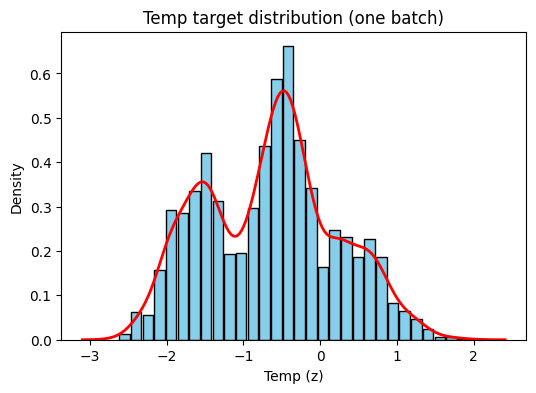

In [ ]:
#Sanity check on one batch
batch = next(iter(train_loader))
print("x shape:", batch.x.shape, " [batch*S, T*F]")
print("edge_index:", batch.edge_index.shape, " edge_weight:", batch.edge_weight.shape)
print("y shape:", batch.y.shape, " [batch*S, K]")

plt.figure(figsize=(6,4))

plt.hist(
    batch.y.flatten().numpy().ravel(),
    bins=30,
    rwidth=0.9,
    color="skyblue",
    edgecolor="black",
    density=True
)

sns.kdeplot(
    batch.y.flatten().numpy().ravel(),
    color="red",
    linewidth=2
)

plt.title("Temp target distribution (one batch)")
plt.xlabel("Temp (z)")
plt.ylabel("Density")
plt.show()

In [ ]:
import os, json, time, torch

save_dir = "./processed"; os.makedirs(save_dir, exist_ok=True)
stamp = time.strftime("%Y%m%d-%H%M%S")

artifact_pt = {
    "edge_index": edge_index.cpu(),
    "edge_weight": edge_weight.cpu(),
    "coords": torch.tensor(coords, dtype=torch.float32),
    "common_sids": torch.tensor(common_sids, dtype=torch.int32),
    "node_order_sids": torch.tensor(node_order_sids, dtype=torch.int32),
}
torch.save(artifact_pt, f"{save_dir}/intel_pipeline_{stamp}.pt")

manifest = {
    "timestamp": stamp,
    "seed": int(globals().get("SEED", 42)),
    "T": int(T),
    "K": int(K),
    "sensor_cols": sensor_cols,
    "splits_counts": {"train": int(len(df_train)), "val": int(len(df_val)), "test": int(len(df_test))},
    "shapes": {
        "edge_index": list(edge_index.size()),
        "edge_weight": list(edge_weight.size()),
        "coords": [int(coords.shape[0]), int(coords.shape[1])]
    }
}
with open(f"{save_dir}/intel_pipeline_{stamp}.json", "w") as f:
    json.dump(manifest, f, indent=2)

print("Saved:", f"{save_dir}/intel_pipeline_{stamp}.pt")
print("Saved:", f"{save_dir}/intel_pipeline_{stamp}.json")

Saved: ./processed/intel_pipeline_20251008-152636.pt
Saved: ./processed/intel_pipeline_20251008-152636.json


In [ ]:
#Train GCN
NUM_EPOCHS = 50
PATIENCE = 7

train_loss_hist, val_loss_hist = [], []
best = float("inf"); wait = 0; best_state = None

# Get the input features dimension from the training loader
# Ensure train_loader is defined and has at least one batch
try:
    batch = next(iter(train_loader))
    in_feats = batch.x.size(-1)
    out_feats = batch.y.size(-1) if batch.y.ndim > 1 else 1
except StopIteration:
    raise RuntimeError("Train loader is empty. Cannot determine input/output dimensions.")


model = TwoLayerGCN(in_feats=in_feats, hidden_feats=32, out_feats=out_feats, dropout=0.2).to(device)
opt = Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()


for ep in range(1, NUM_EPOCHS + 1):
    model.train(); tl = 0.0; ntr = 0
    for batch in train_loader:
        batch = batch.to(device)
        opt.zero_grad()
        y_hat = model(batch.x, batch.edge_index, batch.edge_weight)
        loss = mse(y_hat, batch.y)
        loss.backward(); opt.step()
        tl += loss.item() * batch.num_graphs; ntr += batch.num_graphs
    train_loss_hist.append(tl / max(1, ntr))

    model.eval(); vl = 0.0; nva = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            v = mse(model(batch.x, batch.edge_index, batch.edge_weight), batch.y)
            vl += v.item() * batch.num_graphs; nva += batch.num_graphs
    val_epoch = vl / max(1, nva); val_loss_hist.append(val_epoch)

    if val_epoch < best - 1e-6:
        best = val_epoch; wait = 0
        best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= PATIENCE: break

gcn_history = {"name": "GCN", "train_loss": train_loss_hist, "val_loss": val_loss_hist}
if best_state is not None:
    model.load_state_dict(best_state)
print(f"Training done: epochs={len(train_loss_hist)}, best_val={best:.4f}")

Training done: epochs=50, best_val=0.1579


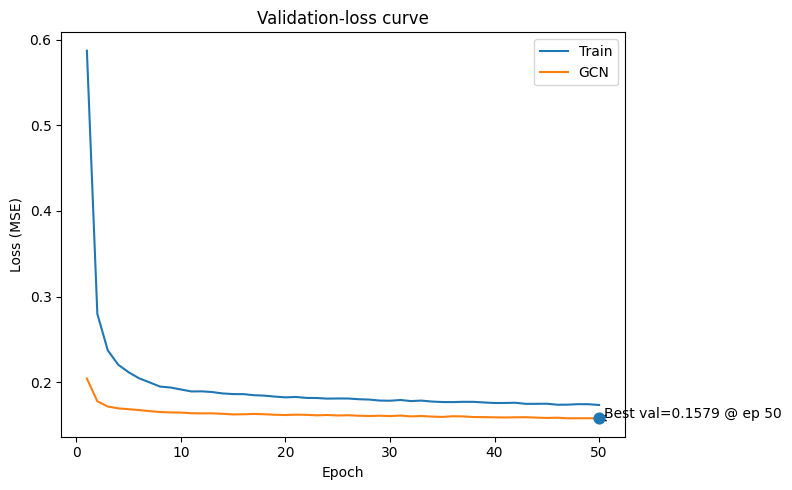

In [ ]:
#Validation-loss curve with best-config annotation
if 'gcn_history' not in globals():
    print("gcn_history not found.")
else:
    val = np.asarray(gcn_history['val_loss'], dtype=float)
    trn = np.asarray(gcn_history.get('train_loss', []), dtype=float)
    ep = np.arange(1, len(val)+1)

    plt.figure(figsize=(8,5))
    if trn.size: plt.plot(ep, trn, label="Train")
    plt.plot(ep, val, label=gcn_history.get('name',"GCN"))
    best_ep = int(val.argmin()+1); best_val = float(val.min())
    plt.scatter([best_ep], [best_val], s=60, zorder=5)
    plt.annotate(f"Best val={best_val:.4f} @ ep {best_ep}",
                 xy=(best_ep, best_val), xytext=(best_ep+0.5, best_val),
                 arrowprops=dict(arrowstyle="->"))
    plt.xlabel("Epoch"); plt.ylabel("Loss (MSE)")
    plt.title("Validation-loss curve")
    plt.legend(); plt.tight_layout(); plt.show()

*`VARIABLE EXPERIMENTS`*

In [ ]:
#Model
import itertools, random
import pandas as pd
import numpy as np

class TwoLayerGCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, out_feats)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = self.relu(x)
        x = self.drop(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [ ]:
#Hyperparameter grid
grid_lr = [1e-3, 3e-3, 1e-2, 3e-2]
grid_hidden_feats = [8, 16, 32]
grid_dropout = [0.0, 0.2, 0.5]
grid_weight_decay = [0.0, 5e-4, 1e-3]

#Build configurations
all_configs = []
for lr in grid_lr:
  for hid in grid_hidden_feats:
    for drop in grid_dropout:
      for wd in grid_weight_decay:
        all_configs.append({
            "lr": lr,
            "hidden_feats": hid,
            "dropout": drop,
            "weight_decay": wd
        })

#Subset sample
MAX_CONFIGS = min(24, len(all_configs))
if len(all_configs) > MAX_CONFIGS:
    idxs = np.random.default_rng(42).choice(len(all_configs), size=MAX_CONFIGS, replace=False)
    configs = [all_configs[i] for i in idxs]
else:
    configs = all_configs

In [ ]:
#Define input dims and run sweep
batch = next(iter(train_loader))
in_feats = batch.x.size(-1)
out_feats = batch.y.size(-1) if batch.y.ndim > 1 else 1

#Helpers
def train_one_model(cfg, epochs):
    model = TwoLayerGCN(in_feats, cfg["hidden_feats"], out_feats, dropout=cfg["dropout"]).to(device)
    opt = Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    loss_fn = nn.MSELoss()

    train_losses, val_losses = [], []

    for _ in range(epochs):
        #Train
        model.train()
        ep_tr = []
        for b in train_loader:
            b = b.to(device)
            opt.zero_grad()
            pred = model(b.x, b.edge_index, b.edge_weight)
            loss = loss_fn(pred.view(-1), b.y.view(-1))
            loss.backward()
            opt.step()
            ep_tr.append(loss.item())
        train_losses.append(float(np.mean(ep_tr)))

        # Validate
        model.eval()
        ep_val = []
        with torch.no_grad():
            for b in val_loader:
                b = b.to(device)
                pred = model(b.x, b.edge_index, b.edge_weight)
                vloss = loss_fn(pred.view(-1), b.y.view(-1)).item()
                ep_val.append(vloss)
        val_losses.append(float(np.mean(ep_val)))

    return model, train_losses, val_losses

In [ ]:
#Fast sweep
SWEEP_EPOCHS = 10
results = []
for cfg in configs:
    _, _, val_losses = train_one_model(cfg, SWEEP_EPOCHS)
    results.append({
        "lr": cfg["lr"],
        "hidden_feats": cfg["hidden_feats"],
        "dropout": cfg["dropout"],
        "weight_decay": cfg["weight_decay"],
        "val_mse": float(np.mean(val_losses[-5:]))
    })

In [ ]:
#Summarize sweep
df = pd.DataFrame(results).copy()
eps = 1e-12
df["val_mse_log10"] = np.log10(df["val_mse"] + eps)

best_idx = df["val_mse"].idxmin()
best_row = df.loc[best_idx]

print("Best configuration from SWEEP (50 epochs):")
print(
    f"  hidden_feats={int(best_row['hidden_feats'])}, "
    f"dropout={best_row['dropout']:.2f}, "
    f"weight_decay={best_row['weight_decay']:.1e}, "
    f"lr={best_row['lr']:.1e}, "
    f"Val MSE={best_row['val_mse']:.6f}, "
    f"log10(Val MSE)={best_row['val_mse_log10']:.3f}"
)

top5 = (
    df.sort_values("val_mse")
      .loc[:, ["hidden_feats","dropout","weight_decay","lr","val_mse","val_mse_log10"]]
      .head(5)
      .reset_index(drop=True)
)
print("\nTop 5 configs by Validation MSE (50-epoch sweep):")
print(top5.to_string(index=False))

df.sort_values("val_mse").to_csv("hyperparam_sweep_results.csv", index=False)

Best configuration from SWEEP (50 epochs):
  hidden_feats=32, dropout=0.00, weight_decay=5.0e-04, lr=3.0e-02, Val MSE=0.156133, log10(Val MSE)=-0.807

Top 5 configs by Validation MSE (50-epoch sweep):
 hidden_feats  dropout  weight_decay    lr  val_mse  val_mse_log10
           32      0.0        0.0005 0.030 0.156133      -0.806505
           32      0.0        0.0010 0.010 0.157728      -0.802092
           16      0.0        0.0005 0.010 0.157866      -0.801710
           32      0.0        0.0005 0.003 0.161888      -0.790785
           16      0.0        0.0000 0.030 0.162266      -0.789772


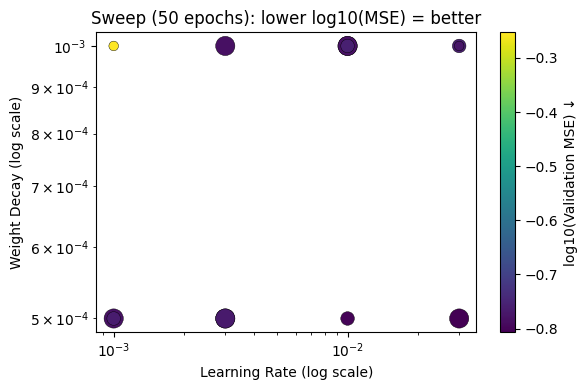

In [ ]:
#Scatter plot
plt.figure(figsize=(6,4))
sc = plt.scatter(
    df['lr'].astype(float), df['weight_decay'].astype(float),
    s=(df['hidden_feats'].astype(float) * 6),
    c=df['val_mse_log10'].astype(float), edgecolor="k", linewidths=.3
)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Weight Decay (log scale)")
plt.title("Sweep (50 epochs): lower log10(MSE) = better")
cbar = plt.colorbar(sc); cbar.set_label("log10(Validation MSE) ↓")
plt.tight_layout(); plt.show()

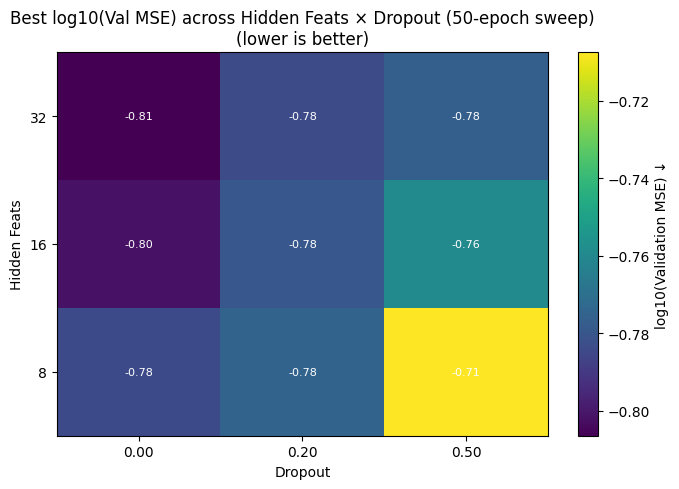

<Figure size 600x400 with 0 Axes>

In [ ]:
#Heatmap (best log10(MSE) across hidden_feats × dropout)
d = df.groupby(['hidden_feats','dropout'], as_index=False)['val_mse_log10'].min()
heat = d.pivot(index='hidden_feats', columns='dropout', values='val_mse_log10').sort_index()
plt.figure(figsize=(7,5))
ax = plt.imshow(heat.values, aspect='auto', origin='lower')
plt.xticks(range(len(heat.columns)), [str(c) for c in heat.columns])
plt.yticks(range(len(heat.index)), [str(i) for i in heat.index])
plt.xlabel("Dropout")
plt.ylabel("Hidden Feats")
plt.title("Best log10(Val MSE) across Hidden Feats × Dropout (50-epoch sweep)\n(lower is better)")
cbar = plt.colorbar(ax); cbar.set_label("log10(Validation MSE) ↓")
plt.xticks(range(len(heat.columns)), [f"{c:.2f}" for c in heat.columns])
plt.yticks(range(len(heat.index)), [str(i) for i in heat.index])
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        val = heat.values[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color="white")
plt.tight_layout()
plt.show()
plt.tight_layout(); plt.show()

In [ ]:
#Retain best configuration
class EarlyStopper:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

BEST_EPOCHS = 200
best_cfg = {
    "lr": float(best_row["lr"]),
    "hidden_feats": int(best_row["hidden_feats"]),
    "dropout": float(best_row["dropout"]),
    "weight_decay": float(best_row["weight_decay"]),
}

model = TwoLayerGCN(in_feats, best_cfg["hidden_feats"], out_feats, dropout=best_cfg["dropout"]).to(device)
opt = Adam(model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["weight_decay"])
loss_fn = nn.MSELoss()

stopper = EarlyStopper(patience=20)
train_losses, val_losses = [], []
best_model_wts = None

for epoch in range(1, BEST_EPOCHS+1):
    # train
    model.train()
    ep_tr = []
    for b in train_loader:
        b = b.to(device)
        opt.zero_grad()
        pred = model(b.x, b.edge_index, b.edge_weight)
        loss = loss_fn(pred.view(-1), b.y.view(-1))
        loss.backward()
        opt.step()
        ep_tr.append(loss.item())
    train_losses.append(float(np.mean(ep_tr)))

    #validate
    model.eval()
    ep_val = []
    with torch.no_grad():
        for b in val_loader:
            b = b.to(device)
            pred = model(b.x, b.edge_index, b.edge_weight)
            vloss = loss_fn(pred.view(-1), b.y.view(-1)).item()
            ep_val.append(vloss)
    val_mean = float(np.mean(ep_val))
    val_losses.append(val_mean)

    #save best model
    if val_mean <= min(val_losses):
        best_model_wts = model.state_dict().copy()
        torch.save(best_model_wts, "best_gnn_model.pt")

    stopper(val_mean)
    if stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

#load best model
model.load_state_dict(torch.load("best_gnn_model.pt"))

final_val = float(min(val_losses))
final_val_log = np.log10(final_val + eps)

print("\nFinal retrain (best config, early-stopped):")
print(
    f"  hidden_feats={best_cfg['hidden_feats']}, "
    f"dropout={best_cfg['dropout']:.2f}, "
    f"weight_decay={best_cfg['weight_decay']:.1e}, "
    f"lr={best_cfg['lr']:.1e}, "
    f"Best Val MSE={final_val:.6f}, "
    f"log10(Val MSE)={final_val_log:.3f}"
)

Early stopping at epoch 63

Final retrain (best config, early-stopped):
  hidden_feats=32, dropout=0.00, weight_decay=5.0e-04, lr=3.0e-02, Best Val MSE=0.144850, log10(Val MSE)=-0.839


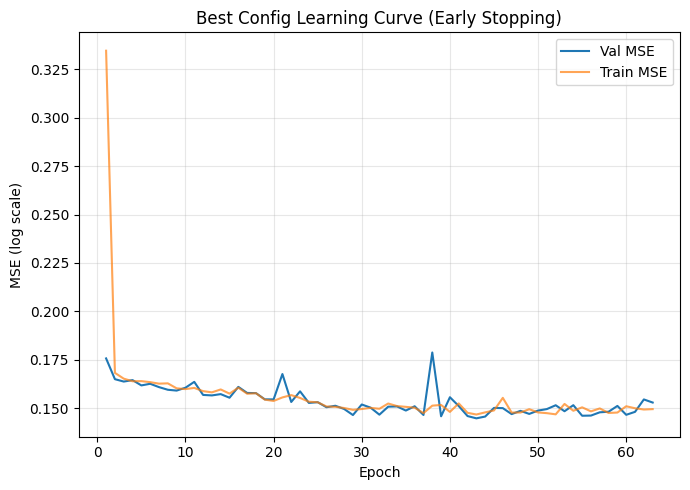

In [ ]:
#Learning curve
plt.figure(figsize=(7,5))
plt.plot(range(1, len(val_losses)+1), val_losses, label="Val MSE")
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train MSE", alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("MSE (log scale)")
plt.title("Best Config Learning Curve (Early Stopping)")
plt.legend(); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

In [ ]:
#Pearson r for best config
from scipy.stats import pearsonr

def _collect_preds(loader, mdl):
    y_true, y_pred = [], []
    mdl.eval()
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            p = mdl(b.x, b.edge_index, b.edge_weight)
            y_true.append(b.y.detach().cpu().numpy().ravel())
            y_pred.append(p.detach().cpu().numpy().ravel())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    r, _ = pearsonr(y_true, y_pred)
    mse_val = np.mean((y_true - y_pred)**2)
    return r, mse_val

r_val, mse_val_check = _collect_preds(val_loader, model)
r_test, mse_test_check = _collect_preds(test_loader, model)

compare_rows = [
    {"split":"val",  "log10_mse": np.log10(max(1e-12, mse_val_check)),  "pearson_r": float(r_val)},
    {"split":"test", "log10_mse": np.log10(max(1e-12, mse_test_check)), "pearson_r": float(r_test)},
]
pearson_df = pd.DataFrame(compare_rows)
display(pearson_df)

if 'comparison_df' in globals():
    comparison_df = pd.concat([comparison_df, pearson_df.assign(model="GCN(best)")], ignore_index=True)

,split,log10_mse,pearson_r
0,val,-0.841082,0.891323
1,test,-0.835926,0.891092


In [ ]:
#Test set evaluation
model.eval()
test_losses = []
with torch.no_grad():
    for b in test_loader:
        b = b.to(device)
        pred = model(b.x, b.edge_index, b.edge_weight)
        tloss = loss_fn(pred.view(-1), b.y.view(-1)).item()
        test_losses.append(tloss)

final_test = float(np.mean(test_losses))
final_test_log = np.log10(final_test + eps)

print("\nTest Set Evaluation (best checkpoint):")
print(f"  Test MSE={final_test:.6f}, log10(Test MSE)={final_test_log:.3f}")


Test Set Evaluation (best checkpoint):
  Test MSE=0.145977, log10(Test MSE)=-0.836


**EVALUATION AND COMPARISON**

*`METRICS`*

In [ ]:
#Gather predictions and true targets
all_sensors.append(np.repeat(batch.sensor_id.cpu().numpy(), batch.y.size(1)))

model.eval()
all_preds, all_trues, all_sensors = [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        y_hat = model(batch.x, batch.edge_index, batch.edge_weight)
        all_preds.append(y_hat.view(-1).cpu().numpy())
        all_trues.append(batch.y.view(-1).cpu().numpy())
        all_sensors.append(np.repeat(np.arange(batch.num_nodes), batch.y.size(1)))

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_trues)
sensor_idx = np.concatenate(all_sensors)

print(f"Collected {len(y_true)} samples from {len(np.unique(sensor_idx))} sensors")

Collected 46176 samples from 1664 sensors


In [ ]:
#Overall metrics
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse_val = mean_squared_error(y_true, y_pred)
pearson_r, p_val = pearsonr(y_true, y_pred)

print(f"\nOverall Metrics:")
print(f"MSE = {mse_val:.4f}, log10(MSE) = {np.log10(mse_val+1e-12):.3f}")
print(f"Pearson r = {pearson_r:.4f} (p = {p_val:.2e})")


Overall Metrics:
MSE = 0.1771, log10(MSE) = -0.752
Pearson r = 0.8669 (p = 0.00e+00)


In [ ]:
#Delta labeling helper
TEMP_STD_C = globals().get("TEMP_STD_C", None)

def _delta_vals(series):
    if TEMP_STD_C is None:
        return series, "ΔTemperature (z)"
    return series * float(TEMP_STD_C), "ΔTemperature (°C)"

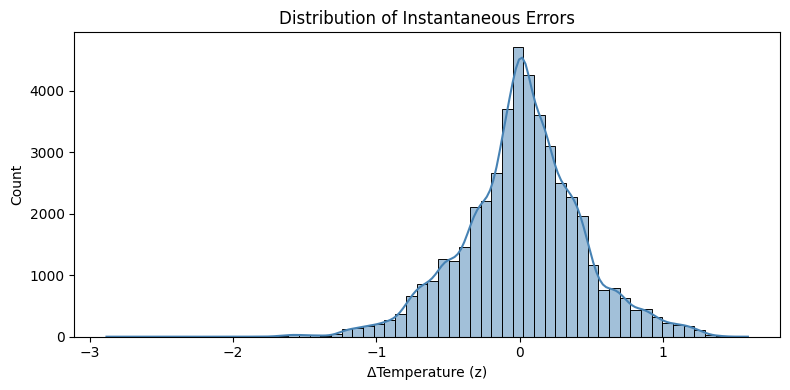

Min error: -2.88, Max error: 1.59


In [ ]:
#Instantaneous error
instant_errors = y_pred - y_true
vals, ylab = _delta_vals(instant_errors)

plt.figure(figsize=(8,4))
sns.histplot(vals, bins=60, kde=True, color="steelblue")
plt.title("Distribution of Instantaneous Errors")
plt.xlabel(ylab); plt.ylabel("Count")
plt.tight_layout(); plt.show()

print(f"Min error: {instant_errors.min():.2f}, Max error: {instant_errors.max():.2f}")

In [ ]:
#Per sensor error distribution
err_df = pd.DataFrame({
    "sensor_id": sensor_idx.astype(int),
    "error": instant_errors
})
per_sensor = (
    err_df.groupby("sensor_id")["error"]
          .agg(n="size", bias="mean", std="std",
               min_err="min", max_err="max",
               mse=lambda x: np.mean(x**2))
          .reset_index()
)
per_sensor["rmse"] = np.sqrt(per_sensor["mse"])
 #Show worst 15 by RMSE (rounded)
table = (per_sensor.sort_values("rmse", ascending=False)
                   .loc[:, ["sensor_id","n","rmse","bias","std","min_err","max_err"]]
                   .round(4)
                   .head(15)
                   .reset_index(drop=True))
print("\nWorst 15 sensors by RMSE (test):")
display(table)


Worst 15 sensors by RMSE (test):


,sensor_id,n,rmse,bias,std,min_err,max_err
0,634,27,1.0101,-0.5355,0.8728,-1.7780,0.6079
1,354,30,0.9984,-0.1772,0.9993,-1.2777,1.2964
2,793,27,0.9972,-0.4583,0.9026,-2.8817,0.7470
3,1310,27,0.9872,-0.4907,0.8730,-1.6696,0.6787
4,1206,27,0.9839,-0.1965,0.9825,-1.6150,0.9293
5,1654,27,0.9815,0.2840,0.9575,-1.1989,1.2860
6,1414,27,0.9800,-0.4805,0.8704,-1.6826,0.5403
7,302,30,0.9618,-0.2640,0.9407,-1.1343,1.2692
8,926,27,0.9211,-0.3850,0.8528,-1.2663,1.1185
9,1554,27,0.9068,0.4724,0.7887,-0.9425,1.2782


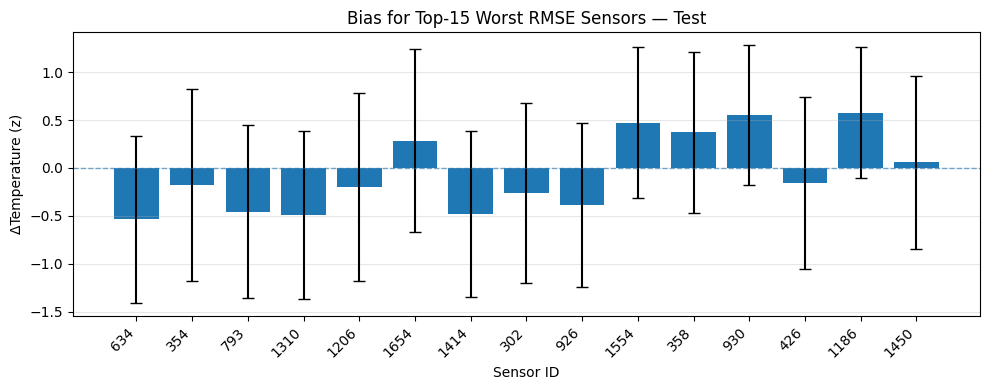

In [ ]:
#Bias chart for top 15 sensors
top15 = per_sensor.sort_values("rmse", ascending=False).head(15)

bias_vals, ylab = _delta_vals(top15["bias"].values)
err_vals, _ = _delta_vals(top15["std"].values)
plt.figure(figsize=(10,4))
plt.bar(top15["sensor_id"].astype(str), bias_vals, yerr=err_vals, capsize=4)
plt.axhline(0, ls="--", lw=1, alpha=.6)
plt.title("Bias for Top-15 Worst RMSE Sensors — Test")
plt.xlabel("Sensor ID"); plt.ylabel(ylab)
plt.xticks(rotation=45, ha="right"); plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

In [ ]:
try:
    SIDS = np.array(common_sids, dtype=int)
except NameError:
    # fallback: if your dataset was built in sensor_id-sorted order
    SIDS = np.array(sorted(df_all['sensor_id'].unique()), dtype=int)

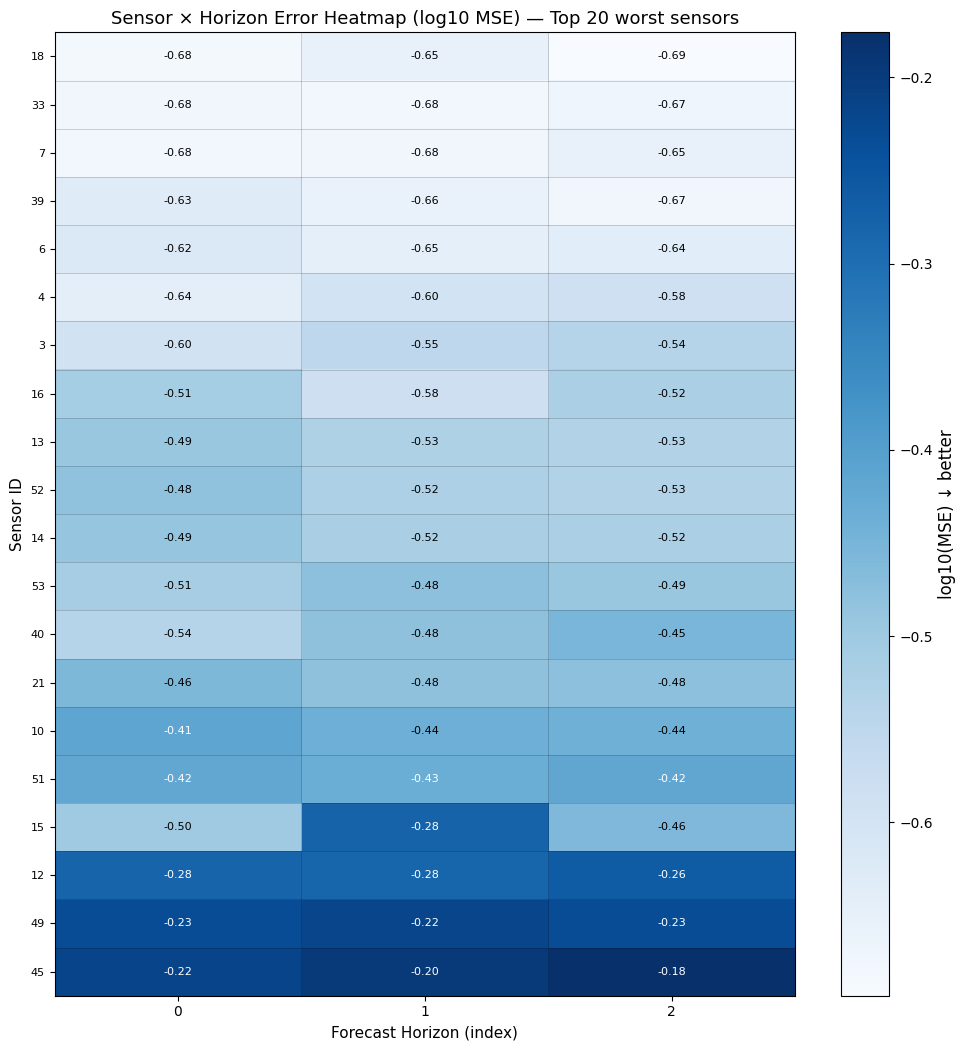

{'Heatmap worst (row 0)': 45, 'Heatmap least-bad (last row)': 18}


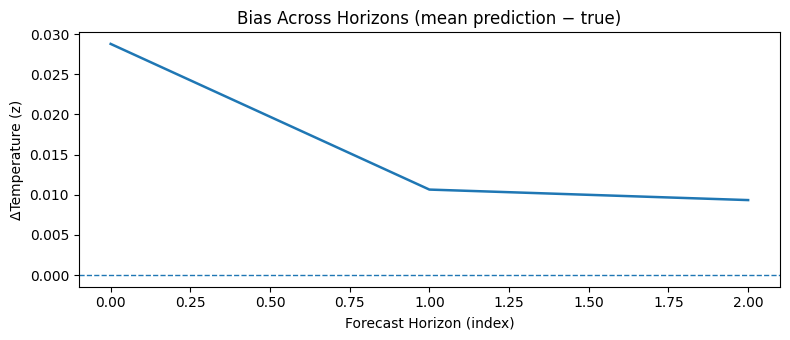

In [ ]:
#Heatmap
#Collect predictions/targets with sensor & horizon indices
model.eval()
all_pred, all_true, all_sid, all_h = [], [], [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        yhat = model(batch.x, batch.edge_index, batch.edge_weight)
        N, H = yhat.shape[0], batch.y.shape[1]
        # Ensure N matches the number of nodes in the batch
        batch_sids = batch.sensor_id.cpu().numpy() # Assuming sensor_id is available in the batch
        assert N == len(batch_sids), "Mismatch: node count vs sensor ID list in batch"
        all_pred.append(yhat.view(-1).cpu().numpy())
        all_true.append(batch.y.view(-1).cpu().numpy())
        # Use sensor IDs from the batch
        all_sid.append(np.repeat(batch_sids, H))
        all_h.append(np.tile(np.arange(H), N))

y_pred_h = np.concatenate(all_pred)
y_true_h = np.concatenate(all_true)
sid_h = np.concatenate(all_sid).astype(int)
hor_h = np.concatenate(all_h).astype(int)

#Build per (sensor, horizon) MSE and log10(MSE)
err = y_pred_h - y_true_h
df_h = pd.DataFrame({"sensor_id": sid_h, "horizon": hor_h, "err": err})
mse_sh = (
    df_h.groupby(["sensor_id", "horizon"])["err"]
        .apply(lambda x: np.mean(x**2)).reset_index(name="mse")
)
mse_sh["log10_mse"] = np.log10(mse_sh["mse"] + 1e-12)

#Choose sensors: worst by overall RMSE (using TRUE IDs)
rmse_s = (
    df_h.groupby("sensor_id")["err"]
        .apply(lambda x: np.sqrt(np.mean(x**2)))
        .reset_index(name="rmse")
        .sort_values("rmse", ascending=False)
)
TOP_K = min(20, rmse_s.shape[0])
sel_sensors = rmse_s.head(TOP_K)["sensor_id"].tolist()   # keep ranking order

# Build heat matrix; keep worst→less-worst row order
heat = (
    mse_sh[mse_sh["sensor_id"].isin(sel_sensors)]
    .pivot(index="sensor_id", columns="horizon", values="log10_mse")
    .loc[sel_sensors]
)

# Plot heatmap
vals = heat.values
rows, cols = vals.shape
vmin, vmax = float(vals.min()), float(vals.max())
mid = (vmin + vmax) / 2.0

plt.figure(figsize=(10, 0.38*rows + 3))
im = plt.imshow(vals, origin="lower", aspect="auto", cmap="Blues", vmin=vmin, vmax=vmax)
cb = plt.colorbar(im); cb.set_label("log10(MSE) ↓ better", fontsize=12)

plt.title(f"Sensor × Horizon Error Heatmap (log10 MSE) — Top {TOP_K} worst sensors", fontsize=13)
plt.xlabel("Forecast Horizon (index)", fontsize=11)
plt.ylabel("Sensor ID", fontsize=11)
plt.xticks(np.arange(cols), np.arange(cols), fontsize=10)
plt.yticks(np.arange(rows), [str(s) for s in sel_sensors], fontsize=8)

#cell borders
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which="minor", color="k", linewidth=0.4, alpha=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

#value labels with auto-contrast
for i in range(rows):
    for j in range(cols):
        val = vals[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center",
                 fontsize=8, color=("white" if val > mid else "black"))

plt.tight_layout()
plt.show()

#summary
print({
    "Heatmap worst (row 0)": int(sel_sensors[0]),
    "Heatmap least-bad (last row)": int(sel_sensors[-1])
})

#Horizon-wise bias check (mean error across all sensors)
bias_h = df_h.groupby("horizon")["err"].mean().reset_index()
bias_vals, ylab = _delta_vals(bias_h["err"].values)
plt.figure(figsize=(8,3.5))
plt.plot(bias_h["horizon"], bias_vals, linewidth=1.8)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Bias Across Horizons (mean prediction − true)")
plt.xlabel("Forecast Horizon (index)"); plt.ylabel(ylab)
plt.tight_layout(); plt.show()

*`COMPARATIVE ANALYSIS`*

In [ ]:
#Extract train and test X/y from loaders
import numpy as np
from sklearn.preprocessing import StandardScaler

#Flatten loaders into full arrays
def loader_to_xy(loader):
    Xs, ys = [], []
    with torch.no_grad():
        for b in loader:
            Xs.append(b.x.cpu().numpy())
            ys.append(b.y.cpu().numpy())
    return np.vstack(Xs), np.vstack(ys).ravel()

def predict_loader(model, loader, device):
    preds = []
    model.eval()
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            yhat = model(b.x, b.edge_index, b.edge_weight)
            preds.append(yhat.view(-1).cpu().numpy())
    return np.concatenate(preds)

X_train_full, y_train_full = loader_to_xy(train_loader)
X_test_full,  y_test_full  = loader_to_xy(test_loader)
y_pred_full = predict_loader(model, test_loader, device)

In [ ]:
#Subsample for baseline
rng = np.random.default_rng(42)
train_n = min(100_000, len(X_train_full))
test_n = min(50_000,  len(X_test_full))
train_idx = rng.choice(len(X_train_full), size=train_n, replace=False)
test_idx = rng.choice(len(X_test_full),  size=test_n,  replace=False)

X_train, y_train = X_train_full[train_idx], y_train_full[train_idx]
X_test,  y_test  = X_test_full[test_idx],  y_test_full[test_idx]
y_gnn = y_pred_full[test_idx]

In [ ]:
#Standardize features and fit baselines
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor


scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

lin = LinearRegression().fit(X_train, y_train)

sgd = SGDRegressor(
    max_iter=1000,
    tol=1e-3,
    random_state=42
).fit(X_train, y_train)

rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
).fit(X_train, y_train)

In [ ]:
#Evaluate models
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MSE": mse,
        "log10(MSE)": np.log10(mse + 1e-12),
        "Pearson_r": pearsonr(y_true, y_pred)[0],
    }

results = {
    "GNN": get_metrics(y_test, y_gnn),
    "LinearReg": get_metrics(y_test, lin.predict(X_test)),
    "SGDRegressor": get_metrics(y_test, sgd.predict(X_test)),
    "RandomForest": get_metrics(y_test, rf.predict(X_test)),
}

df = pd.DataFrame(results).T
df = df.round({"MSE":6, "log10(MSE)":4, "Pearson_r":4})
df = df.sort_values("MSE")  # best first
display(df)

,MSE,log10(MSE),Pearson_r
GNN,0.182315,-0.7392,0.8586
RandomForest,0.679337,-0.1679,0.0958
LinearReg,0.683832,-0.1651,0.0510
SGDRegressor,0.699169,-0.1554,0.0384


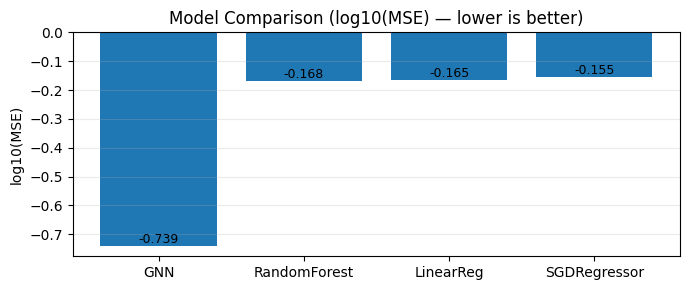

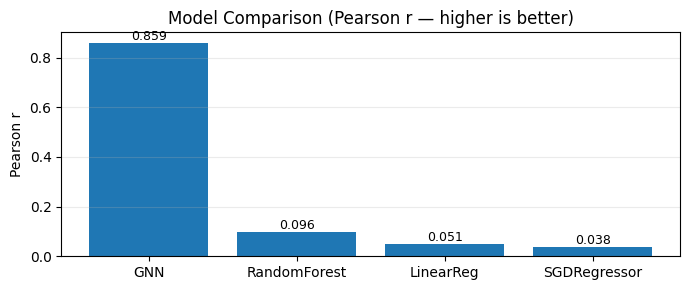

In [ ]:
def bar_with_labels(x, y, title, ylabel, ascending=True):
    y_array = np.array(y) # Convert list to numpy array
    order = np.argsort(y_array) if ascending else np.argsort(-y_array)
    x_ord = [x[i] for i in order]
    y_ord = [y[i] for i in order]

    fig, ax = plt.subplots(figsize=(7,3))
    bars = ax.bar(x_ord, y_ord)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(axis="y", alpha=0.25)
    for b in bars:
        ax.text(b.get_x() + b.get_width()/2, b.get_height(),
                f"{b.get_height():.3f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

bar_with_labels(
    x=df.index.tolist(),
    y=df["log10(MSE)"].values.tolist(),
    title="Model Comparison (log10(MSE) — lower is better)",
    ylabel="log10(MSE)",
    ascending=True
)

bar_with_labels(
    x=df.index.tolist(),
    y=df["Pearson_r"].values.tolist(),
    title="Model Comparison (Pearson r — higher is better)",
    ylabel="Pearson r",
    ascending=False
)

In [ ]:
#Percent improvement over baseline
df_imp = df.copy()

def _get_mse(df_like, name="GNN"):
    if "Model" in df_like.columns:
        g_mse = float(df_like.loc[df_like["Model"] == name, "MSE"].iloc[0])
        base_mse = float(df_like.loc[df_like["Model"] != name, "MSE"].min())
    else:
        g_mse = float(df_like.loc[name, "MSE"])
        base_mse = float(df_like.loc[df_like.index != name, "MSE"].min())
    return g_mse, base_mse

g_mse, best_base_mse = _get_mse(df_imp, "GNN")
impr_pct = (best_base_mse - g_mse) / best_base_mse * 100.0
df_imp["%_improvement_vs_best_baseline"] = ""
if "Model" in df_imp.columns:
    df_imp.loc[df_imp["Model"] == "GNN", "%_improvement_vs_best_baseline"] = f"{impr_pct:.2f}%"
else:
    df_imp.loc["GNN", "%_improvement_vs_best_baseline"] = f"{impr_pct:.2f}%"

display(df_imp)
print(f"GNN vs best baseline improvement: {impr_pct:.2f}%")

,MSE,log10(MSE),Pearson_r,%_improvement_vs_best_baseline
GNN,0.182315,-0.7392,0.8586,73.16%
RandomForest,0.679337,-0.1679,0.0958,
LinearReg,0.683832,-0.1651,0.0510,
SGDRegressor,0.699169,-0.1554,0.0384,


GNN vs best baseline improvement: 73.16%


In [ ]:
#Statistical tests
from scipy.stats import ttest_rel

if "X_test_full" not in globals() or "y_test_full" not in globals():
    X_test_full, y_test_full = loader_to_xy(test_loader)

#GNN preds for the full test set
y_pred_full = predict_loader(model, test_loader, device)

#Use the SAME subset as classical baselines
#(train_idx/test_idx created in your "Subsample for baselines" cell)
if "test_idx" in globals():
    y_true_sub = y_test_full[test_idx]
    gnn_preds  = y_pred_full[test_idx]
    baseline_preds = lin.predict(X_test)
else:
    #compare on full test set
    y_true_sub = y_test_full
    gnn_preds  = y_pred_full
    baseline_preds = lin.predict(X_test_full)

#Paired t-test on absolute errors (per-sample)
err_gnn  = np.abs(y_true_sub - gnn_preds)
err_base = np.abs(y_true_sub - baseline_preds)
t_stat, p_val = ttest_rel(err_base, err_gnn)  #positive t → GNN smaller error on average

print(f"Paired t-test (abs error): t={t_stat:.4f}, p={p_val:.4e}")
print("Statistically significant improvement (p<0.05)" if p_val < 0.05 else "No statistically significant difference")

Paired t-test (abs error): t=83.0001, p=0.0000e+00
Statistically significant improvement (p<0.05)


{'Deep-dive from heatmap': {'worst': 45, 'least_bad': 18}}


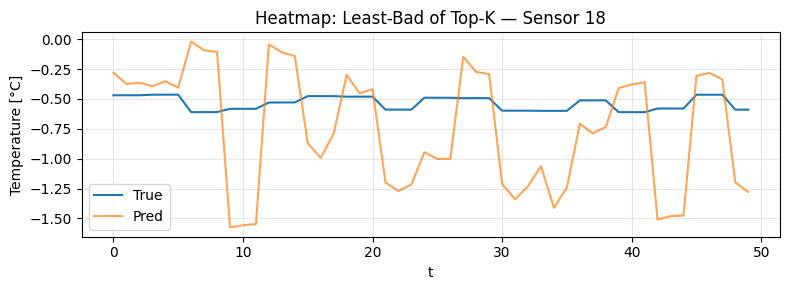

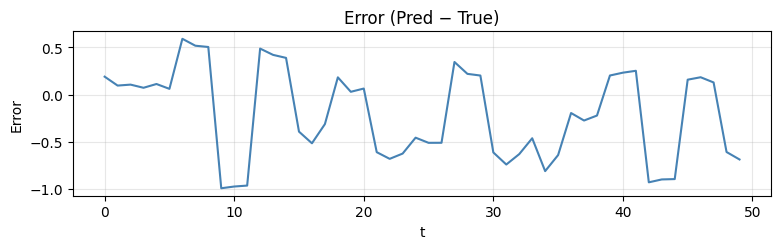

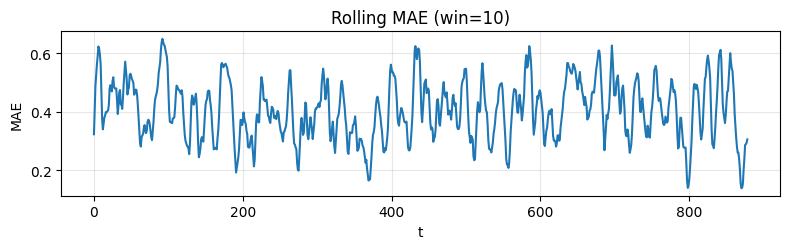

Sensor 18: n=888, RMSE=0.459, bias=-0.124


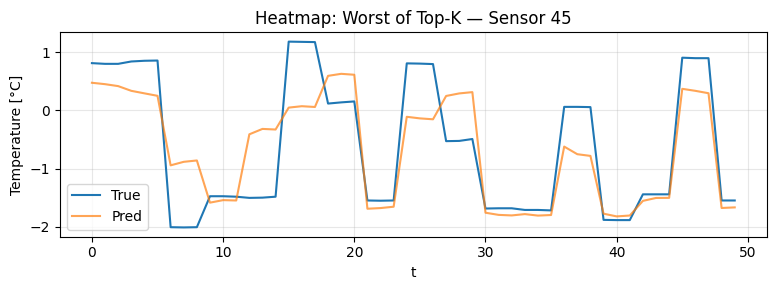

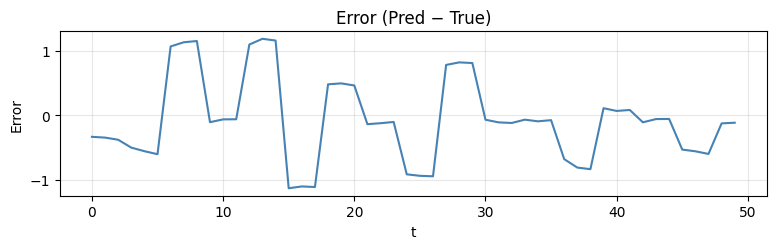

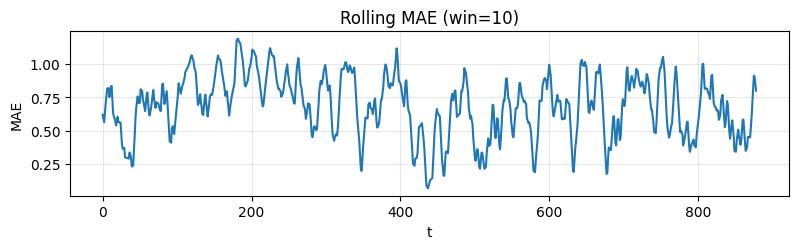

Sensor 45: n=888, RMSE=0.798, bias=-0.158


In [ ]:
#Worst vs least-bad sensor deep dive from error heatmap
sensor_idx = sid_h.astype(int)
y_true     = y_true_h
y_pred     = y_pred_h
assert len(sensor_idx) == len(y_true) == len(y_pred)

# pick sensors from the current heatmap ranking
worst_sid    = int(sel_sensors[0])       # row 0 of heatmap
leastbad_sid = int(sel_sensors[-1])      # last row
print({"Deep-dive from heatmap": {"worst": worst_sid, "least_bad": leastbad_sid}})

def sensor_deepdive(sensor_id, title="", max_plot=50, win=10):
    i = (sensor_idx == sensor_id)
    yt, yp = y_true[i], y_pred[i]
    n = min(len(yt), max_plot); t = np.arange(n)

    plt.figure(figsize=(8,3)); plt.plot(t, yt[:n], label="True"); plt.plot(t, yp[:n], label="Pred", alpha=.7)
    plt.title(f"{title} — Sensor {sensor_id}"); plt.xlabel("t"); plt.ylabel("Temperature [°C]")
    plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

    err = yp - yt
    plt.figure(figsize=(8,2.6)); plt.plot(err[:n], color="steelblue"); plt.title("Error (Pred − True)")
    plt.xlabel("t"); plt.ylabel("Error"); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

    if len(err) >= win:
        ker = np.ones(win)/win
        rmae = np.convolve(np.abs(err), ker, mode="valid")
        plt.figure(figsize=(8,2.6)); plt.plot(rmae); plt.title(f"Rolling MAE (win={win})")
        plt.xlabel("t"); plt.ylabel("MAE"); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

    print(f"Sensor {sensor_id}: n={len(yt)}, RMSE={np.sqrt(np.mean(err**2)):.3f}, bias={np.mean(err):.3f}")

sensor_deepdive(leastbad_sid, "Heatmap: Least-Bad of Top-K")
sensor_deepdive(worst_sid,    "Heatmap: Worst of Top-K")


*`ABLATION STUDIES`*

In [ ]:
#Config
SEEDS = [42, 123, 2025]
EPOCHS = 5
FEATS = ['temperature','humidity','light','voltage']
IN_FEATS = next(iter(train_loader)).x.size(-1)
OUT_FEATS = next(iter(val_loader)).y.size(-1) if next(iter(val_loader)).y.ndim > 1 else 1

In [ ]:
#Helpers
def train_one_epoch_loop(model, opt, loss_fn, loader, keep_idx=None):
    model.train()
    ep_losses = []
    for batch in loader:
        batch = batch.to(device)
        # Ensure keep_idx is a numpy array for indexing if not None
        current_keep_idx = np.array(keep_idx) if isinstance(keep_idx, list) else keep_idx
        x = batch.x[:, current_keep_idx] if current_keep_idx is not None else batch.x
        opt.zero_grad()
        pred = model(x, batch.edge_index, batch.edge_weight)
        loss = loss_fn(pred.view(-1), batch.y.view(-1))
        loss.backward()
        opt.step()
        ep_losses.append(loss.item())
    return float(np.mean(ep_losses))

@torch.no_grad()
def eval_metrics(model, loader, keep_idx=None):
    model.eval()
    losses, biases, corrs = [], [], []
    for batch in loader:
        batch = batch.to(device)
        x = batch.x
        if keep_idx is not None:
            x = x[:, keep_idx]
        y_hat = model(x, batch.edge_index, batch.edge_weight).view(-1).detach().cpu().numpy()
        y_true = batch.y.view(-1).cpu().numpy()
        losses.append(mean_squared_error(y_true, y_hat))
        biases.append(np.mean(y_hat - y_true))
        corrs.append(np.corrcoef(y_true, y_hat)[0,1])
    return float(np.mean(losses)), float(np.mean(biases)), float(np.mean(corrs))

Drop-One Feature Ablation (mean ± std over seeds):


,dropped,MSE_mean,MSE_std,Bias_mean,Bias_std,r_mean,r_std
0,humidity,0.1922,0.0115,0.0068,0.0093,0.8559,0.0080
1,light,0.1981,0.0125,-0.0018,0.0015,0.8483,0.0105
2,temperature,0.3916,0.0138,0.0143,0.0174,0.6654,0.0149
3,voltage,0.2005,0.0088,-0.0092,0.0026,0.8472,0.0071


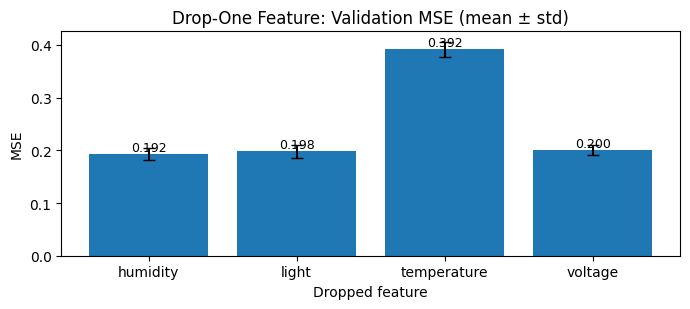

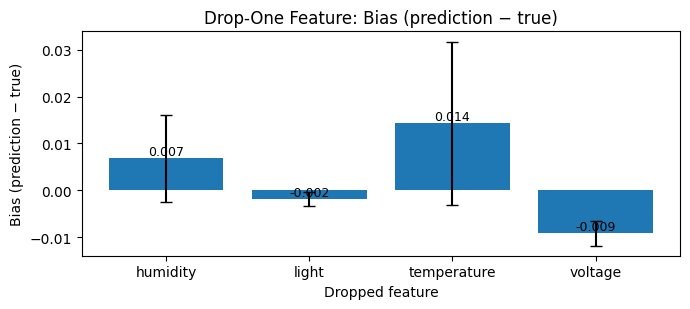

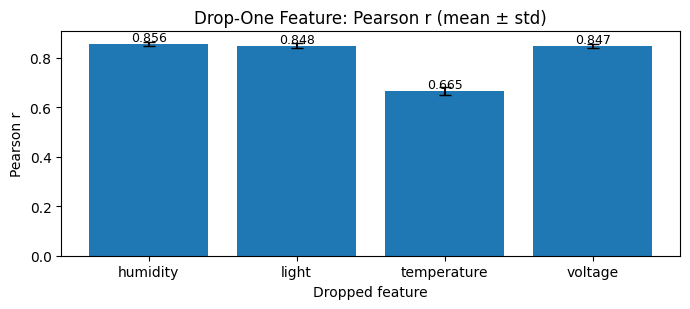

In [ ]:
#Drop one feature
drop_records = []

def apply_mask(x, keep_idx, in_dim):
    # broadcast multiply with shape [F]
    mask = torch.zeros(in_dim, device=x.device)
    mask[keep_idx] = 1.0
    return x * mask  # same shape as input to the model

in_dim = next(iter(train_loader)).x.size(1)

for seed in SEEDS:
    np.random.seed(seed); torch.manual_seed(seed)
    for i, f in enumerate(FEATS):
        keep_idx = [j for j in range(len(FEATS)) if j != i]  # keep all but one

        model = TwoLayerGCN(in_dim, best_cfg["hidden_feats"], OUT_FEATS, dropout=0.2).to(device)
        opt = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        loss_fn = nn.MSELoss()

        # train
        model.train()
        for ep in range(EPOCHS):
            ep_losses = []
            for batch in train_loader:
                batch = batch.to(device)
                x_masked = apply_mask(batch.x, keep_idx, in_dim)
                opt.zero_grad()
                y_hat = model(x_masked, batch.edge_index, batch.edge_weight)
                loss = loss_fn(y_hat.view(-1), batch.y.view(-1))
                loss.backward()
                opt.step()
                ep_losses.append(loss.item())

        # eval (with mask)
        model.eval()
        mses, biases, corrs = [], [], []
        for batch in val_loader:
            batch = batch.to(device)
            x_masked = apply_mask(batch.x, keep_idx, in_dim)
            with torch.no_grad():
                y_hat = model(x_masked, batch.edge_index, batch.edge_weight).view(-1)
            y_true = batch.y.view(-1)
            mses.append(mean_squared_error(y_true.cpu().numpy(), y_hat.cpu().numpy()))
            biases.append(float((y_hat - y_true).mean().item()))
            # Pearson r
            yt = y_true.cpu().numpy(); yp = y_hat.cpu().numpy()
            corrs.append(float(np.corrcoef(yt, yp)[0,1]))

        drop_records.append({
            "dropped": f,
            "seed": seed,
            "MSE": float(np.mean(mses)),
            "Bias": float(np.mean(biases)),
            "r": float(np.mean(corrs))
        })

drop_df = pd.DataFrame(drop_records)
drop_sum = (
    drop_df.groupby("dropped")
           .agg(MSE_mean=("MSE","mean"), MSE_std=("MSE","std"),
                Bias_mean=("Bias","mean"), Bias_std=("Bias","std"),
                r_mean=("r","mean"), r_std=("r","std"))
           .reset_index()
)

print("Drop-One Feature Ablation (mean ± std over seeds):")
display(drop_sum.round(4))


plt.figure(figsize=(7,3.2))
bars = plt.bar(drop_sum["dropped"], drop_sum["MSE_mean"], yerr=drop_sum["MSE_std"], capsize=4)
plt.title("Drop-One Feature: Validation MSE (mean ± std)")
plt.xlabel("Dropped feature"); plt.ylabel("MSE")
for b, v in zip(bars, drop_sum["MSE_mean"]):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.2))
bars = plt.bar(drop_sum["dropped"], drop_sum["Bias_mean"], yerr=drop_sum["Bias_std"], capsize=4)
plt.title("Drop-One Feature: Bias (prediction − true)")
plt.xlabel("Dropped feature"); plt.ylabel("Bias (prediction − true)")
for b, v in zip(bars, drop_sum["Bias_mean"]):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.2))
bars = plt.bar(drop_sum["dropped"], drop_sum["r_mean"], yerr=drop_sum["r_std"], capsize=4)
plt.title("Drop-One Feature: Pearson r (mean ± std)")
plt.xlabel("Dropped feature"); plt.ylabel("Pearson r")
for b, v in zip(bars, drop_sum["r_mean"]):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()

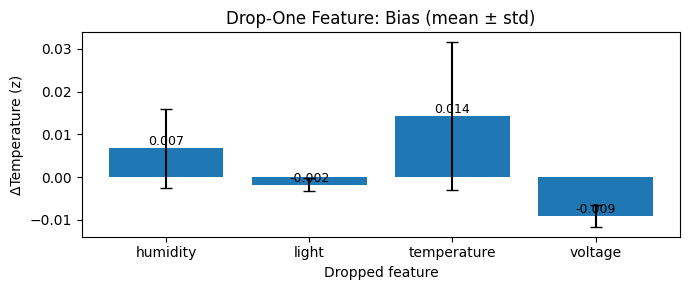

In [ ]:
#Add ΔTemperature (°C) labels
def _bias_to_C(series):
    TEMP_STD = globals().get("TEMP_STD", None)
    if TEMP_STD is None:
        return series, "Bias (pred−true, z-units)"
    return series * float(TEMP_STD), "ΔTemperature (°C)"

#Re-plot bias bars
y_vals, y_label = _delta_vals(drop_sum["Bias_mean"])
y_errs, _ = _delta_vals(drop_sum["Bias_std"])
plt.figure(figsize=(7,3))
bars = plt.bar(drop_sum["dropped"], y_vals, yerr=y_errs, capsize=4)
for b, v in zip(bars, y_vals):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.title("Drop-One Feature: Bias (mean ± std)")
plt.xlabel("Dropped feature"); plt.ylabel(y_label); plt.tight_layout(); plt.show()

Train/Val Split Ablation (mean ± std over seeds):


,train_frac,MSE_mean,MSE_std,Bias_mean,Bias_std,log10(MSE)_mean
0,0.6,0.1795,0.0014,0.0204,0.0116,-0.7459
1,0.7,0.1767,0.0066,0.0041,0.0038,-0.7527
2,0.8,0.1762,0.0050,0.0150,0.0070,-0.7540


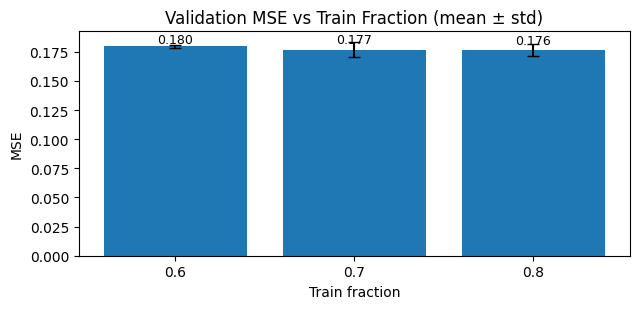

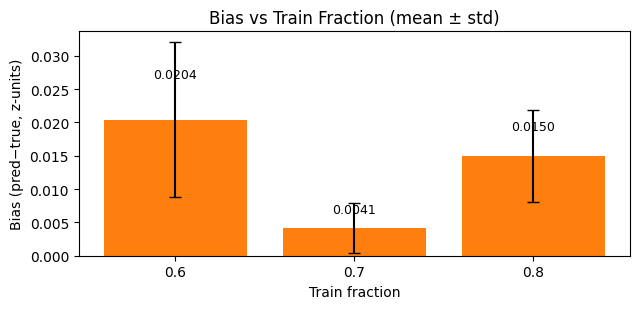

In [ ]:
#Train/Val Split Ablation
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader  # Import PyG DataLoader
import torch, numpy as np

#Helper to build model and optimizer
HID = 32
LR = 1e-3
WD = 1e-2
DROPOUT = 0.2

def make_model(in_feats):
    model = TwoLayerGCN(
        in_feats=in_feats,
        hidden_feats=HID,
        out_feats=OUT_FEATS,
        dropout=DROPOUT
    ).to(device)
    opt = Adam(model.parameters(), lr=LR, weight_decay=WD)
    return model, opt

#Config
SEEDS = [42, 123, 2025]
fractions = [0.6, 0.7, 0.8]
batch_size = getattr(train_loader, "batch_size", 256)
N = len(train_loader.dataset)

split_records = []

#Calculate input feature size
_full_in = next(iter(train_loader)).x.size(-1)

for seed in SEEDS:
    rng = np.random.default_rng(seed)
    perm = rng.permutation(N)

    for frac in fractions:
        n_train = int(frac * N)
        train_idx = perm[:n_train].tolist()
        val_idx = perm[n_train:].tolist()

        #Subset and DataLoader setup
        train_subset = Subset(train_loader.dataset, train_idx)
        val_subset = Subset(train_loader.dataset, val_idx)

        _loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        _vloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        in_feats = _full_in
        model, opt = make_model(in_feats)
        loss_fn = nn.MSELoss()

        for _ in range(EPOCHS):
            train_one_epoch_loop(model, opt, loss_fn, _loader, keep_idx=None)

        mse_val, bias_val, _ = eval_metrics(model, _vloader, keep_idx=None)
        split_records.append({
            "train_frac": frac,
            "seed": seed,
            "mse": mse_val,
            "bias": bias_val
        })

#Aggregate results
split_df = pd.DataFrame(split_records)
split_sum = (
    split_df.groupby("train_frac")
    .agg(MSE_mean=("mse", "mean"),
         MSE_std=("mse", "std"),
         Bias_mean=("bias", "mean"),
         Bias_std=("bias", "std"))
    .reset_index()
)
split_sum["log10(MSE)_mean"] = np.log10(split_sum["MSE_mean"] + 1e-12)

print("Train/Val Split Ablation (mean ± std over seeds):")
display(split_sum.round(4))

#MSE vs Train Fraction
plt.figure(figsize=(6.5, 3.2))
order = split_sum["train_frac"].values
y = split_sum["MSE_mean"].values
yerr = split_sum["MSE_std"].values
bars = plt.bar(order.astype(str), y, yerr=yerr, capsize=4)
for i, v in enumerate(y):
    plt.text(i, y[i] + yerr[i]/2, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.title("Validation MSE vs Train Fraction (mean ± std)")
plt.xlabel("Train fraction")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()

#Bias vs Train Fraction
plt.figure(figsize=(6.5, 3.2))
order = split_sum["train_frac"].values
yb, yb_label = _bias_to_C(split_sum["Bias_mean"].values)
yb_err, _ = _bias_to_C(split_sum["Bias_std"].values)
bars = plt.bar(order.astype(str), yb, yerr=yb_err, capsize=4, color="tab:orange")
for i, v in enumerate(yb):
    plt.text(i, yb[i] + yb_err[i]/2, f"{v:.4f}", ha="center", va="bottom", fontsize=9)
plt.title("Bias vs Train Fraction (mean ± std)")
plt.xlabel("Train fraction")
plt.ylabel(yb_label)
plt.tight_layout()
plt.show()

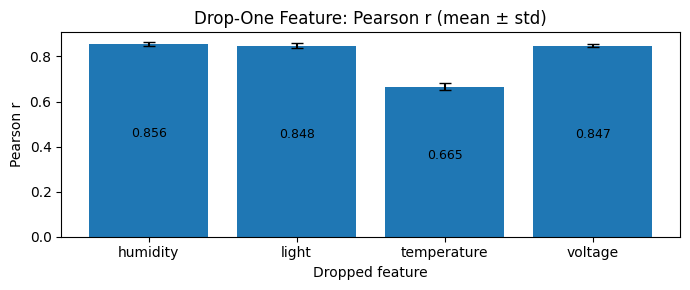

Ablation Summary Tables (with Pearson r added for Drop-One):

DropOneFeature:


,dropped,MSE_mean,MSE_std,Bias_mean,Bias_std,r_mean,r_std
0,humidity,0.1922,0.0115,0.0068,0.0093,0.8559,0.0080
1,light,0.1981,0.0125,-0.0018,0.0015,0.8483,0.0105
2,temperature,0.3916,0.0138,0.0143,0.0174,0.6654,0.0149
3,voltage,0.2005,0.0088,-0.0092,0.0026,0.8472,0.0071



TrainSplit:


,train_frac,MSE_mean,MSE_std,Bias_mean,Bias_std
0,0.6,0.1795,0.0014,0.0204,0.0116
1,0.7,0.1767,0.0066,0.0041,0.0038
2,0.8,0.1762,0.0050,0.0150,0.0070


In [ ]:
if {"r_mean","r_std"}.issubset(drop_sum.columns):
    plt.figure(figsize=(7,3))
    bars = plt.bar(drop_sum["dropped"], drop_sum["r_mean"], yerr=drop_sum["r_std"], capsize=4)
    for b, v in zip(bars, drop_sum["r_mean"]): plt.text(b.get_x()+b.get_width()/2, b.get_height()/2, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
    plt.title("Drop-One Feature: Pearson r (mean ± std)")
    plt.xlabel("Dropped feature"); plt.ylabel("Pearson r"); plt.tight_layout(); plt.show()

#Summary tables
summary = {
    "DropOneFeature": drop_sum.loc[:, ["dropped","MSE_mean","MSE_std","Bias_mean","Bias_std","r_mean","r_std"]],
    "TrainSplit":     split_sum.loc[:, ["train_frac","MSE_mean","MSE_std","Bias_mean","Bias_std"]]  # keep MSE/Bias for split table
}
print("Ablation Summary Tables (with Pearson r added for Drop-One):")
for name, tab in summary.items():
    print(f"\n{name}:"); display(tab.round(4))

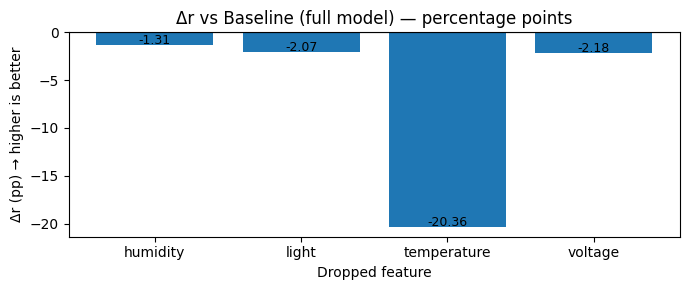

In [ ]:
#Baseline bar chart

def _eval_full_r():
    rs = []
    for seed in SEEDS:
        torch.manual_seed(seed)
        model = TwoLayerGCN(IN_FEATS, hidden_feats=HID, out_feats=OUT_FEATS, dropout=0.2).to(device)
        opt   = Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
        # quick fit (same small loop you used in drop-one)
        for _ in range(EPOCHS):
            train_one_epoch_loop(model, opt, loss_fn, train_loader, keep_idx=None)
        # evaluate r on val
        _, _, r = eval_metrics(model, val_loader, keep_idx=None)  # returns (mse_mean, bias_mean, r_mean)
        rs.append(r)
    return float(np.mean(rs))

r_full_mean = _eval_full_r()

#Δr (percentage points) vs baseline
delta_r_pp = (drop_sum["r_mean"] - r_full_mean) * 100.0
plt.figure(figsize=(7,3))
bars = plt.bar(drop_sum["dropped"], delta_r_pp, color="tab:blue")
for b, v in zip(bars, delta_r_pp): plt.text(b.get_x()+b.get_width()/2, v + (0.2 if v>=0 else -0.2), f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.axhline(0, color="k", linewidth=0.8)
plt.title("Δr vs Baseline (full model) — percentage points")
plt.xlabel("Dropped feature"); plt.ylabel("Δr (pp) → higher is better"); plt.tight_layout(); plt.show()

**FORECASTING**

*`SINGLE-DIMENSIONAL TEMPERATURE FORECAST`*

In [ ]:
#Chronological test subset
# N = len(dataset) # dataset is not defined, use test_ds instead
# test_start = int(np.floor(N * 0.85))
# forecast_idx = list(range(test_start, N))
# forecast_subset = torch.utils.data.Subset(dataset, forecast_idx)
# forecast_loader = torch_geometric.loader.DataLoader(forecast_subset, batch_size=32, shuffle=False)

# Use the already defined test_ds for forecasting
import torch_geometric
forecast_subset = test_ds
forecast_loader = torch_geometric.loader.DataLoader(forecast_subset, batch_size=32, shuffle=False)

# sids_array = np.asarray(dataset.sids) # dataset is not defined
sids_array = np.asarray(forecast_subset.sids)
num_nodes = sids_array.shape[0]
sid_to_pos = {int(s): i for i, s in enumerate(sids_array)}

In [ ]:
#Generate per-sensor predictions
from collections import defaultdict
import torch, numpy as np

all_forecasts = defaultdict(list)
all_truths = defaultdict(list)

# Use common_sids which has the actual sensor IDs
sids_array = np.array(common_sids)
num_nodes = len(sids_array)

model.eval()
with torch.no_grad():
    for batch in forecast_loader:
        batch = batch.to(device)
        yhat = model(batch.x, batch.edge_index, batch.edge_weight)  # [batch*N, K]
        ytru = batch.y  # [batch*N, K]

        # Get batch size
        batch_size = len(batch.ptr) - 1
        K_actual = yhat.shape[1] if yhat.ndim > 1 else 1

        # Reshape to [batch_size, num_nodes, K]
        yhat_np = yhat.cpu().numpy().reshape(batch_size, num_nodes, K_actual)
        ytru_np = ytru.cpu().numpy().reshape(batch_size, num_nodes, K_actual)

        # Iterate over each graph in the batch
        for g in range(batch_size):
            for pos in range(num_nodes):
                sid = int(sids_array[pos])  # Get actual sensor ID from common_sids
                all_forecasts[sid].append(yhat_np[g, pos, :])  # Append K predictions
                all_truths[sid].append(ytru_np[g, pos, :])     # Append K true values

#Convert sensor predictions to data frames
rows = []
for sid in sorted(all_forecasts.keys()):
    preds_list = all_forecasts[sid]
    truths_list = all_truths[sid]

    y_pred = np.concatenate(preds_list)
    y_true = np.concatenate(truths_list)

    for i, (p, t) in enumerate(zip(y_pred, y_true)):
        rows.append({'sensor_id': sid, 'idx': i, 'predicted': float(p), 'true': float(t)})

forecast_df = pd.DataFrame(rows)
display(forecast_df.head(20))
print(f"Sensors: {forecast_df.sensor_id.nunique()} | per-sensor length (min≈max): {forecast_df.groupby('sensor_id').size().min()} – {forecast_df.groupby('sensor_id').size().max()}")
print(f"Unique sensor IDs: {sorted(forecast_df.sensor_id.unique())[:10]}")  # Show first 10 sensor IDs

,sensor_id,idx,predicted,true
0,1,0,-0.899219,-0.914010
1,1,1,-0.884718,-0.918234
2,1,2,-0.908115,-0.926682
3,1,3,-1.189682,-1.070303
4,1,4,-1.092209,-1.066079
5,1,5,-1.049307,-1.070303
6,1,6,1.214755,1.100907
7,1,7,1.258548,1.096683
8,1,8,1.198413,1.100907
9,1,9,-1.722852,-1.703925


Sensors: 52 | per-sensor length (min≈max): 888 – 888
Unique sensor IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]


In [ ]:
forecast_df = pd.DataFrame(rows)

# Show samples from multiple sensors to verify
print("Sample from first 5 sensors:")
for sid in sorted(forecast_df.sensor_id.unique())[:5]:
    sample = forecast_df[forecast_df.sensor_id == sid].head(3)
    display(sample)

print(f"\nSensors: {forecast_df.sensor_id.nunique()} | per-sensor length (min≈max): {forecast_df.groupby('sensor_id').size().min()} – {forecast_df.groupby('sensor_id').size().max()}")
print(f"Unique sensor IDs: {sorted(forecast_df.sensor_id.unique())}")

Sample from first 5 sensors:


,sensor_id,idx,predicted,true
0,1,0,-0.899219,-0.914010
1,1,1,-0.884718,-0.918234
2,1,2,-0.908115,-0.926682


,sensor_id,idx,predicted,true
888,2,0,-1.177509,-1.262087
889,2,1,-1.126874,-1.252220
890,2,2,-1.149446,-1.252220


,sensor_id,idx,predicted,true
1776,3,0,-0.703582,-0.483954
1777,3,1,-0.786671,-0.479343
1778,3,2,-0.808922,-0.470122


,sensor_id,idx,predicted,true
2664,4,0,0.044781,0.574808
2665,4,1,0.020910,0.570487
2666,4,2,-0.016929,0.561846


,sensor_id,idx,predicted,true
3552,6,0,-0.720213,-1.421282
3553,6,1,-0.626434,-1.426588
3554,6,2,-0.676372,-1.426588



Sensors: 52 | per-sensor length (min≈max): 888 – 888
Unique sensor IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54)]


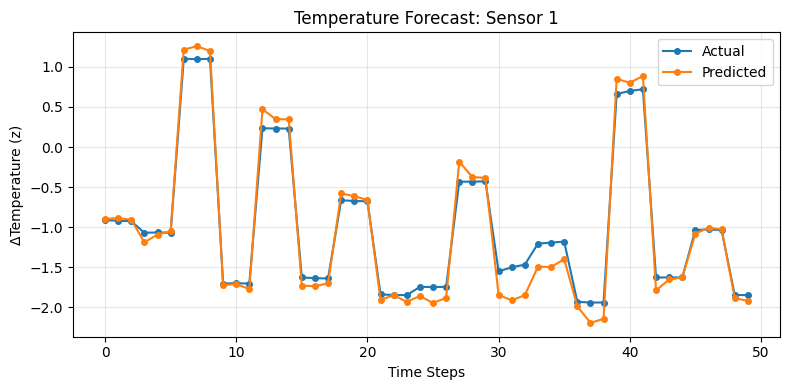

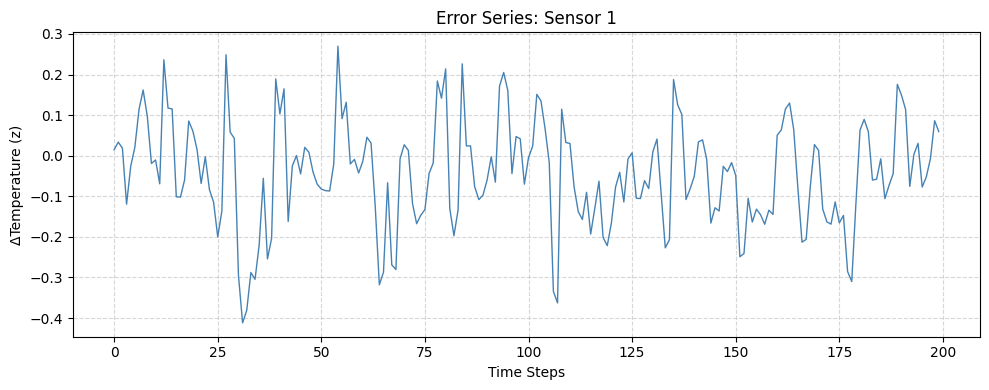

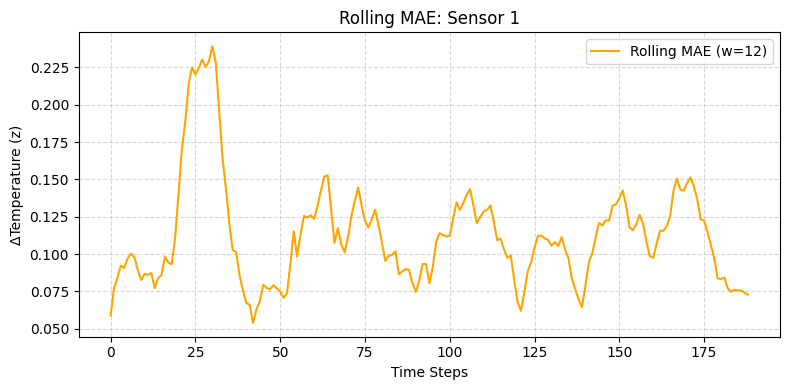

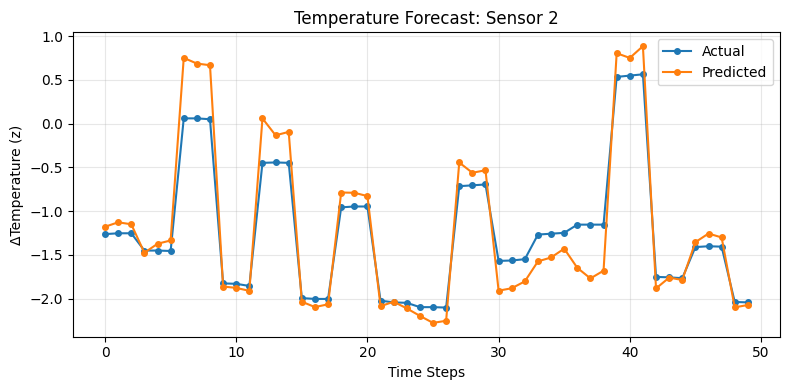

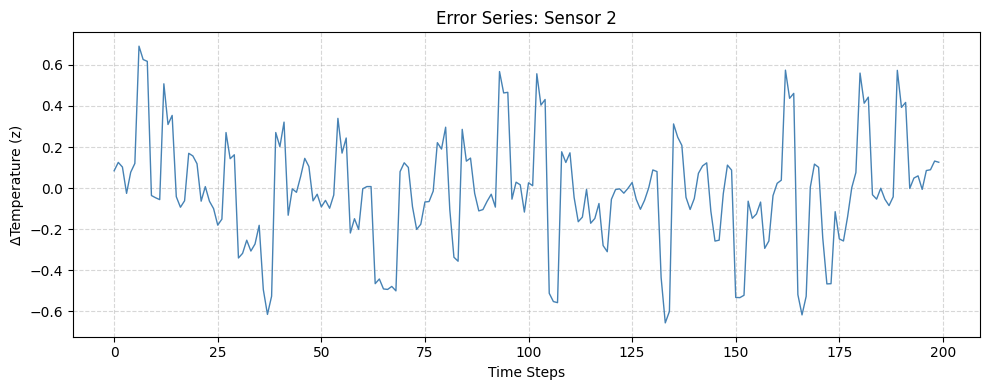

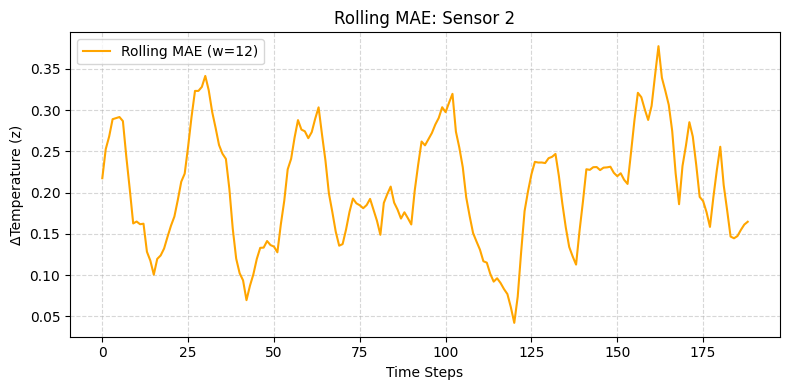

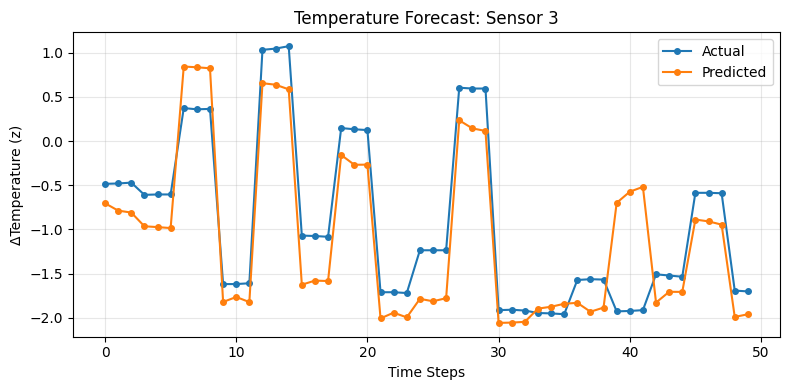

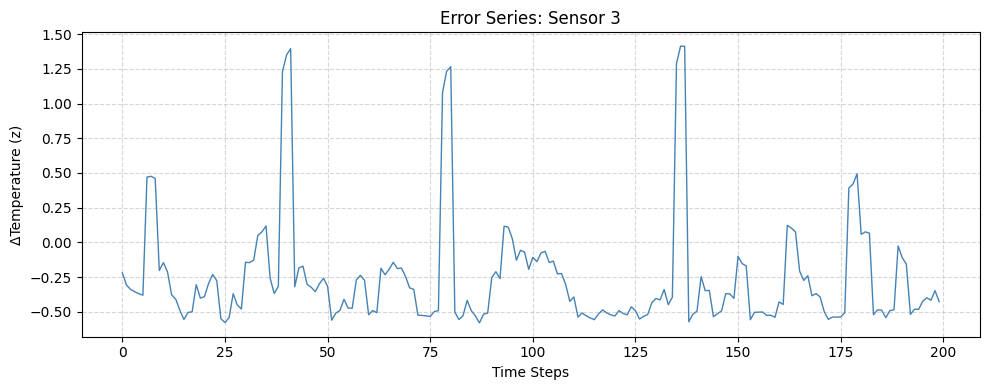

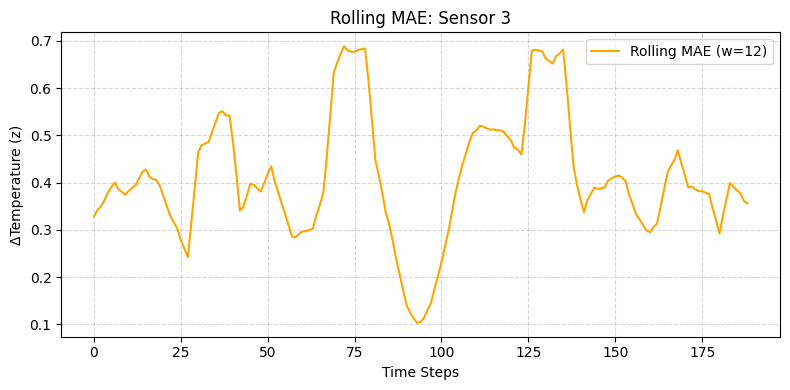

In [ ]:
#Per-sensor plots (pred vs true)
def plot_sensor_series(sensor_id, n_points=50):
    df = forecast_df[forecast_df.sensor_id == sensor_id].head(n_points)
    if df.empty: return

    true_vals, ylabel_temp = _delta_vals(df.true.values)
    pred_vals, _ = _delta_vals(df.predicted.values)

    plt.figure(figsize=(8,4))
    plt.plot(df.idx, true_vals, '-o', label="Actual", markersize=4)
    plt.plot(df.idx, pred_vals, '-o', label="Predicted", markersize=4)
    plt.title(f"Temperature Forecast: Sensor {sensor_id}")
    plt.xlabel("Time Steps"); plt.ylabel(ylabel_temp)
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

def plot_error_series(sensor_id, n_points=200, window=12):
    df = forecast_df[forecast_df.sensor_id == sensor_id].head(n_points)
    if df.empty: return

    err = df.predicted - df.true
    err_vals, ylabel_err = _delta_vals(err.values)

    plt.figure(figsize=(10,4))
    plt.plot(df.idx, err_vals, color="steelblue", linewidth=1)
    plt.title(f"Error Series: Sensor {sensor_id}")
    plt.xlabel("Time Steps"); plt.ylabel(ylabel_err)
    plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

    if len(err) > window:
        mae = np.convolve(np.abs(err), np.ones(window)/window, mode='valid')
        mae_vals, ylabel_mae = _delta_vals(mae)

        plt.figure(figsize=(8,4))
        plt.plot(mae_vals, label=f"Rolling MAE (w={window})", color="orange")
        plt.title(f"Rolling MAE: Sensor {sensor_id}")
        plt.xlabel("Time Steps"); plt.ylabel(ylabel_mae)
        plt.grid(True, linestyle="--", alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

for sid in list(sorted(forecast_df.sensor_id.unique()))[:3]:
    plot_sensor_series(sid, n_points=50)
    plot_error_series(sid, n_points=200, window=12)

In [ ]:
#Quant metrics per sensor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

metrics_rows = []
for sid in sorted(forecast_df.sensor_id.unique()):
    df = forecast_df[forecast_df.sensor_id == sid]
    if df.empty: continue
    mse = mean_squared_error(df.true, df.predicted)
    mae = mean_absolute_error(df.true, df.predicted)
    r, _ = pearsonr(df.true, df.predicted)
    metrics_rows.append({'sensor_id': sid, 'MSE': mse, 'MAE': mae, 'Pearson_r': r})

metrics_df = pd.DataFrame(metrics_rows)
display(metrics_df.head())
print(f"Overall MSE: {metrics_df.MSE.mean():.6f} | MAE: {metrics_df.MAE.mean():.6f} | r̄: {metrics_df.Pearson_r.mean():.4f}")

,sensor_id,MSE,MAE,Pearson_r
0,1,0.018664,0.104556,0.995956
1,2,0.081447,0.218152,0.974982
2,3,0.275169,0.441478,0.855572
3,4,0.247032,0.447204,0.804057
4,6,0.231971,0.420637,0.854736


Overall MSE: 0.177094 | MAE: 0.315948 | r̄: 0.8127


In [ ]:
#Sensor 1 anomaly diagnostics and neighbor contrast
sensor_of_interest = 1
if sensor_of_interest in forecast_df.sensor_id.unique():
    df_sel = forecast_df[forecast_df.sensor_id == sensor_of_interest]
    mae = mean_absolute_error(df_sel.true, df_sel.predicted)
    r, _ = pearsonr(df_sel.true, df_sel.predicted)
    print(f"Sensor {sensor_of_interest}: MAE={mae:.3f}, r={r:.3f}")

Sensor 1: MAE=0.105, r=0.996


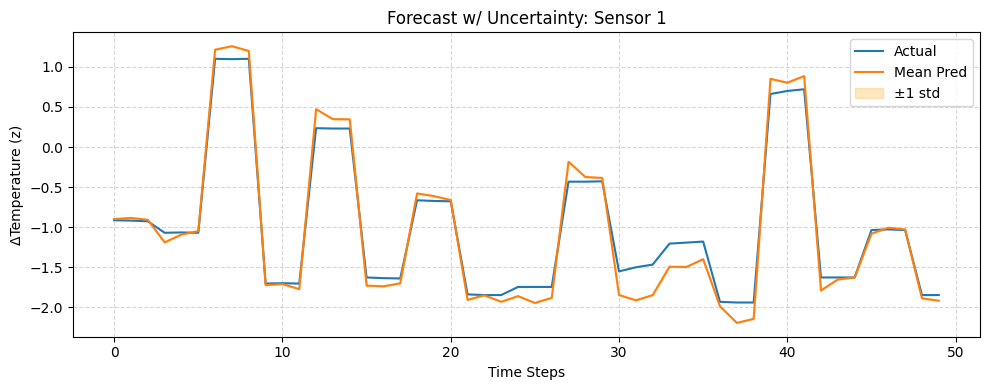

In [ ]:
#Uncertainty representation
def forecast_with_seeds(sensor_id, seeds=[0,1,2,3,4], n_points=50):
    runs = []
    for sd in seeds:
        torch.manual_seed(sd); np.random.seed(sd)
        preds = forecast_df[forecast_df.sensor_id == sensor_id].predicted.values[:n_points]
        runs.append(preds)
    arr = np.stack(runs)
    mean_preds, std_preds = arr.mean(0), arr.std(0)
    true_vals = forecast_df[forecast_df.sensor_id == sensor_id].true.values[:n_points]

    # Apply delta transformation
    true_conv, ylabel = _delta_vals(true_vals)
    mean_conv, _ = _delta_vals(mean_preds)
    std_conv, _ = _delta_vals(std_preds)

    plt.figure(figsize=(10,4))
    plt.plot(true_conv, label="Actual", markersize=4)
    plt.plot(mean_conv, label="Mean Pred", markersize=4)
    plt.fill_between(np.arange(len(mean_conv)), mean_conv-std_conv, mean_conv+std_conv,
                     color='orange', alpha=0.25, label='±1 std')
    plt.title(f"Forecast w/ Uncertainty: Sensor {sensor_id}")
    plt.xlabel("Time Steps"); plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

forecast_with_seeds(sensor_id=1, seeds=[0,1,2,3,4], n_points=50)


Metrics by Forecast Horizon:


,Horizon,MSE,MAE,Pearson_r
0,1,0.176188,0.318077,0.865275
1,2,0.177437,0.314571,0.863278
2,3,0.177901,0.315878,0.863378


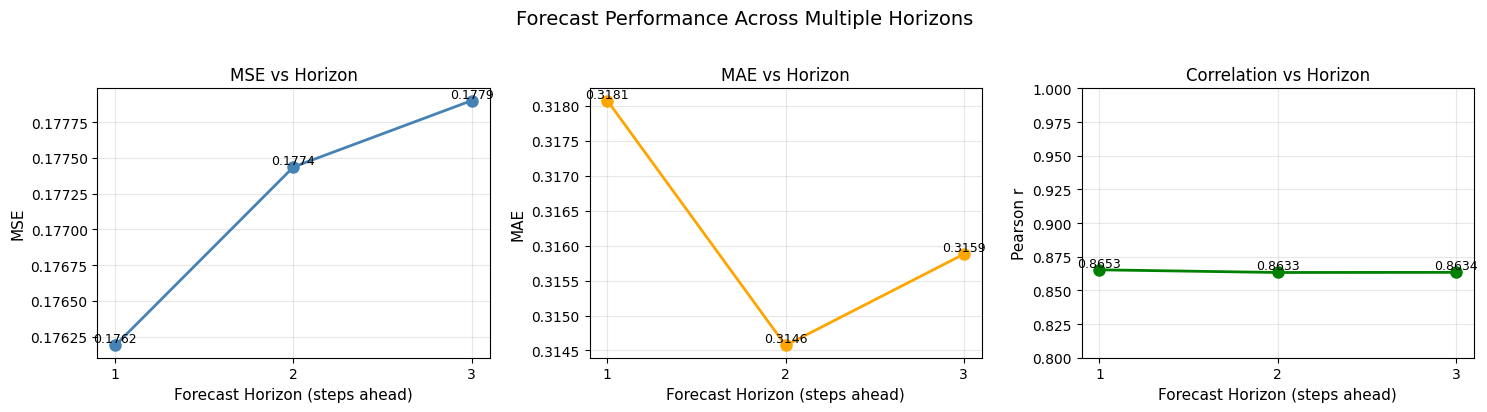

In [ ]:
#Horizon comparison (1, 3, 5)
H_LIST = [1, 2, 3]  # Use K=1,2,3 since the model was trained with K=3
horizon_results = []

with torch.no_grad():
    for batch in forecast_loader:
        batch = batch.to(device)
        yhat = model(batch.x, batch.edge_index, batch.edge_weight)  # [batch*N, K]
        ytru = batch.y  # [batch*N, K]

        batch_size = len(batch.ptr) - 1
        K_actual = ytru.shape[1]  # Should be 3

        # Reshape: [batch_size, num_nodes, K]
        yhat_np = yhat.cpu().numpy().reshape(batch_size, num_nodes, K_actual)
        ytru_np = ytru.cpu().numpy().reshape(batch_size, num_nodes, K_actual)

        #Evaluate each horizon
        for h in H_LIST:
            if h > K_actual:
                continue

            #Extract predictions and truths for horizon h (index h-1)
            pred_h = yhat_np[:, :, h-1].ravel()  # Flatten across batch and nodes
            true_h = ytru_np[:, :, h-1].ravel()

            mse = mean_squared_error(true_h, pred_h)
            mae = mean_absolute_error(true_h, pred_h)
            r = pearsonr(true_h, pred_h)[0]

            horizon_results.append({
                "Horizon": h,
                "MSE": mse,
                "MAE": mae,
                "Pearson_r": r
            })

#Aggregate results
horizon_df = (
    pd.DataFrame(horizon_results)
    .groupby("Horizon", as_index=False)
    .mean()
    .sort_values("Horizon")
)

print("\nMetrics by Forecast Horizon:")
display(horizon_df.round(6))

#Plot metrics vs horizon
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

x = horizon_df["Horizon"].values

#MSE
axes[0].plot(x, horizon_df["MSE"].values, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel("Forecast Horizon (steps ahead)", fontsize=11)
axes[0].set_ylabel("MSE", fontsize=11)
axes[0].set_title("MSE vs Horizon", fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(x)
for i, (xi, yi) in enumerate(zip(x, horizon_df["MSE"].values)):
    axes[0].text(xi, yi, f'{yi:.4f}', ha='center', va='bottom', fontsize=9)

#MAE
axes[1].plot(x, horizon_df["MAE"].values, 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel("Forecast Horizon (steps ahead)", fontsize=11)
axes[1].set_ylabel("MAE", fontsize=11)
axes[1].set_title("MAE vs Horizon", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(x)
for i, (xi, yi) in enumerate(zip(x, horizon_df["MAE"].values)):
    axes[1].text(xi, yi, f'{yi:.4f}', ha='center', va='bottom', fontsize=9)

#Pearson r
axes[2].plot(x, horizon_df["Pearson_r"].values, 'o-', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel("Forecast Horizon (steps ahead)", fontsize=11)
axes[2].set_ylabel("Pearson r", fontsize=11)
axes[2].set_title("Correlation vs Horizon", fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(x)
axes[2].set_ylim([0.8, 1.0])
for i, (xi, yi) in enumerate(zip(x, horizon_df["Pearson_r"].values)):
    axes[2].text(xi, yi, f'{yi:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle("Forecast Performance Across Multiple Horizons", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
#Summary
agg_stats = {
    "Mean MAE": metrics_df.MAE.mean(),
    "Median MAE": metrics_df.MAE.median(),
    "Std MAE": metrics_df.MAE.std(),
    "Best sensor (min MAE)": metrics_df.loc[metrics_df.MAE.idxmin(), "sensor_id"],
    "Worst sensor (max MAE)": metrics_df.loc[metrics_df.MAE.idxmax(), "sensor_id"],
}
print("Aggregate:", agg_stats)

Aggregate: {'Mean MAE': np.float64(0.3159484269733662), 'Median MAE': 0.2915715292363054, 'Std MAE': 0.16085801161967384, 'Best sensor (min MAE)': np.int64(23), 'Worst sensor (max MAE)': np.int64(49)}


*`BEST AND WORST SENSOR`*

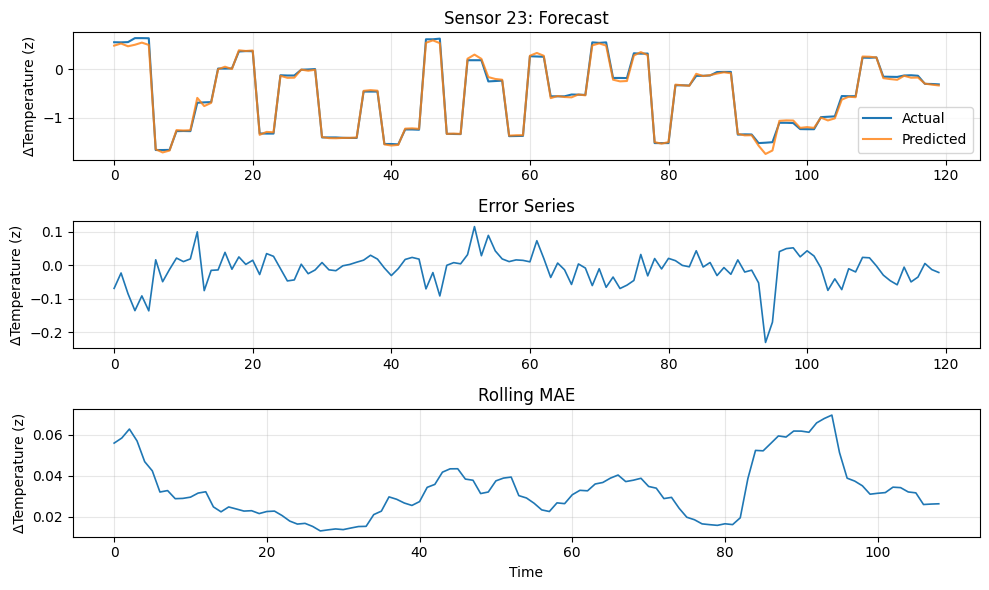

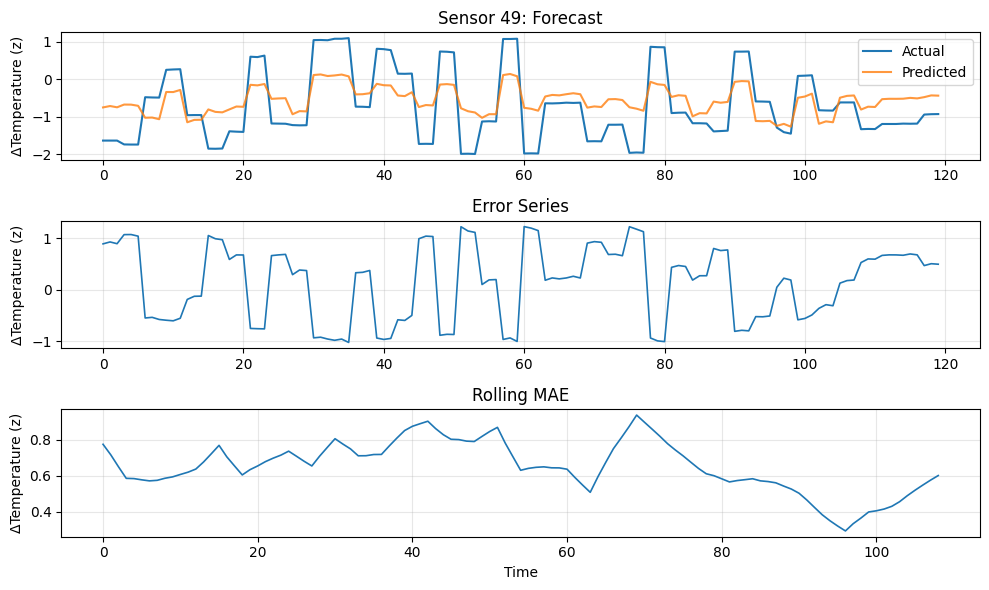

In [ ]:
#Identify best and worst sensor from metrics
best_sid = 23 #min MAE
worst_sid = 49 #max MAE

#Diagnostic visualization
def plot_sensor_forecast(sensor_id, n_points=120, window=12):
    df = forecast_df[forecast_df.sensor_id == sensor_id].head(n_points)
    if df.empty:
        print(f"No data for sensor {sensor_id}")
        return

    y_true = df.true.values
    y_pred = df.predicted.values
    err = y_pred - y_true
    rolling_mae = np.convolve(np.abs(err), np.ones(window)/window, mode='valid')

    #Apply delta transformations
    true_conv, ylabel_temp = _delta_vals(y_true)
    pred_conv, _ = _delta_vals(y_pred)
    err_conv, ylabel_err = _delta_vals(err)
    mae_conv, ylabel_mae = _delta_vals(rolling_mae)

    plt.figure(figsize=(10,6))

    #Actual vs Pred
    plt.subplot(3,1,1)
    plt.grid(alpha=0.3)
    plt.plot(true_conv, label="Actual", lw=1.5)
    plt.plot(pred_conv, label="Predicted", lw=1.5, alpha=0.8)
    plt.title(f"Sensor {sensor_id}: Forecast")
    plt.ylabel(ylabel_temp)
    plt.legend()

    #Error Series
    plt.subplot(3,1,2)
    plt.grid(alpha=0.3)
    plt.plot(err_conv, lw=1.2)
    plt.title("Error Series")
    plt.ylabel(ylabel_err)

    #Rolling MAE
    plt.subplot(3,1,3)
    plt.grid(alpha=0.3)
    plt.plot(mae_conv, lw=1.2)
    plt.title("Rolling MAE")
    plt.ylabel(ylabel_mae)
    plt.xlabel("Time")

    plt.tight_layout()
    plt.show()

#Plot
plot_sensor_forecast(best_sid)
plot_sensor_forecast(worst_sid)

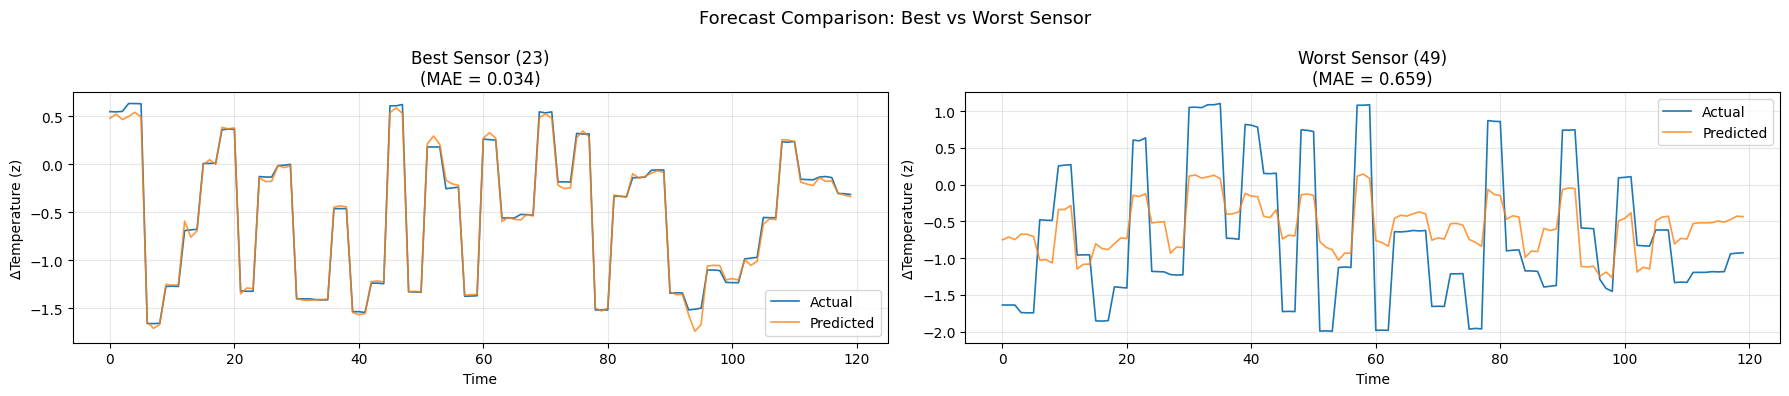

In [ ]:
#comparison of both sensors
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
for ax, sid, title in zip(
    axes,
    [best_sid, worst_sid],
    ['Best Sensor (23)', 'Worst Sensor (49)']
):
    df = forecast_df[forecast_df.sensor_id == sid].head(120)

    true_conv, ylabel = _delta_vals(df.true.values)
    pred_conv, _ = _delta_vals(df.predicted.values)
    mae_value_raw = np.mean(np.abs(df.predicted - df.true))
    mae_value, _ = _delta_vals(np.array([mae_value_raw]))

    ax.plot(true_conv, label="Actual", lw=1.2)
    ax.plot(pred_conv, label="Predicted", lw=1.2, alpha=0.8)
    ax.set_title(f"{title}\n(MAE = {mae_value[0]:.3f})")
    ax.set_xlabel("Time")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle("Forecast Comparison: Best vs Worst Sensor", fontsize=13)
plt.tight_layout()
plt.show()

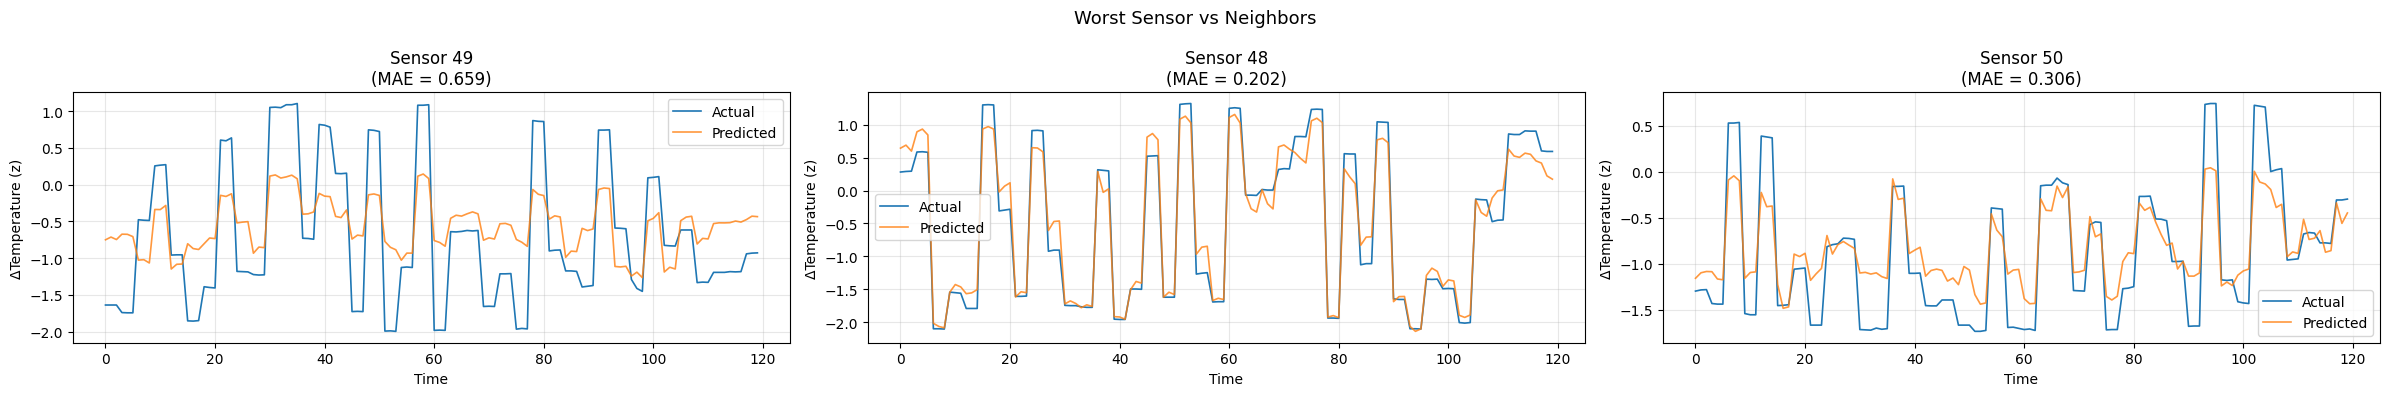

In [ ]:
#Neighborhood contrast for the worst sensor (26)
worst_sid = 49
neighbor_ids = [48, 50]

plt.figure(figsize=(24, 4))
for i, sid in enumerate([worst_sid] + neighbor_ids):
    df = forecast_df[forecast_df.sensor_id == sid].head(120)

    true_conv, ylabel = _delta_vals(df.true.values)
    pred_conv, _ = _delta_vals(df.predicted.values)
    mae_value_raw = np.mean(np.abs(df.predicted - df.true))
    mae_value, _ = _delta_vals(np.array([mae_value_raw]))

    plt.subplot(1, 3, i + 1)
    plt.plot(true_conv, label="Actual", lw=1.2)
    plt.plot(pred_conv, label="Predicted", lw=1.2, alpha=0.8)
    plt.title(f"Sensor {sid}\n(MAE = {mae_value[0]:.3f})")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(alpha=0.3)

plt.suptitle("Worst Sensor vs Neighbors", fontsize=13)
plt.tight_layout()
plt.show()